# Ch 7. Gaussian Processes

In [1]:
import warnings
from pathlib import Path

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotnine as gg
import pymc3 as pm
import seaborn as sns
import theano.tensor as tt
from scipy import stats

# Remove annoying filters from some dated ArViz functions.
warnings.simplefilter(action="ignore", category=UserWarning)

gg.theme_set(gg.theme_minimal())
%config InlineBackend.figure_format = "retina"

data_path = Path("data")

- **Gaussian Process (GP)**: an infinite-dimensional generalization of the Gaussian distribution used to *set a prior on unknown functions*
- topics covered:
    - functions as probabilistic objects
    - kernels
    - Gaussian processes with Gaussian likelihoods
    - Gaussian processes with non-Gaussian likelihoods

## Linear models and non-linear data

- generalized linear models can be expressed as:

$$
\theta = \psi(\phi(X)\beta)
$$

- where:
    - $\theta$: parameter vector for some probability distributions
    - $\psi$: inverse link function (for simple linear regression, $\psi$ is the identity function)
    - $\phi$: the squareroot or a polynomial function
    - $\beta$: vector of values to identify in the fitting process

> Gaussian processes provide a principled solution to modeling arbitrary functions by effectively *letting the data decide on the complexity of the function*, while avoiding, or at least minimizing, the chance of overfitting.

## Modeling functions

- traditionally, we treat $y = f(x)$ as a mapping of values $x$ to $y$
- can represent the function probabilisitically by letting each $y_i$ be a random variable distributed as a Gaussian with a mean and variance
    - no longer a description of a single specific function, but a familly of distributions
- example of two functions with points drawn from distributions
    - *line 1*: each point is independently drawn from a 1-dimensional Gaussian
    - *line 2*: each point is drawn from a Gaussian where the mean for $y_i$ is $y_{i-1}$

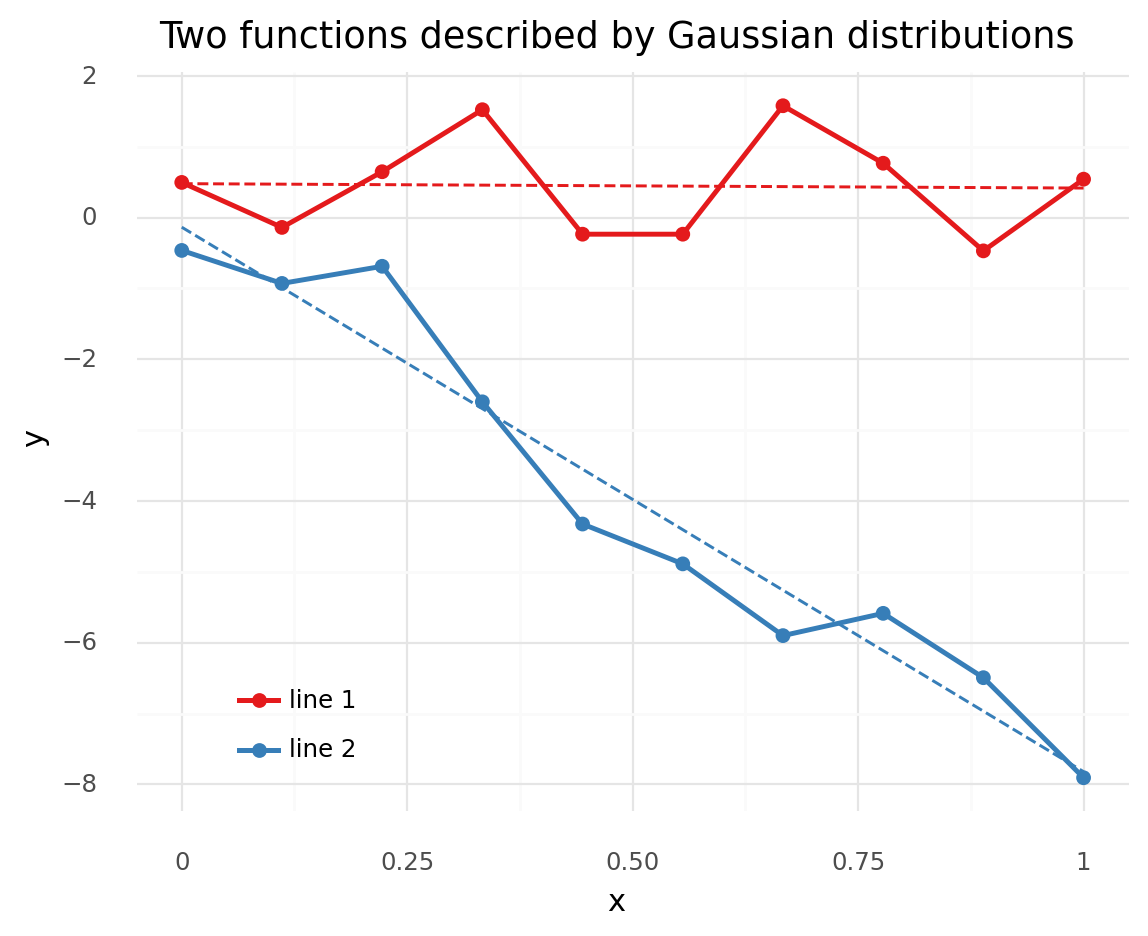

<ggplot: (8791713700238)>

In [2]:
np.random.seed(42)
x = np.linspace(0, 1, 10)
y1 = np.random.normal(0, 1, len(x))
y2 = np.zeros_like(y1)
for i in range(len(x)):
    y2[i] = np.random.normal(y2[i - 1], 1)

d = pd.DataFrame({"x": x, "line 1": y1, "line 2": y2})
d = d.melt(id_vars="x", var_name="group", value_name="y")
(
    gg.ggplot(d, gg.aes(x="x", y="y", color="group"))
    + gg.geom_point(size=2)
    + gg.geom_line(size=1)
    + gg.geom_smooth(method="lm", se=False, size=0.6, linetype="--")
    + gg.scale_color_brewer(type="qual", palette="Set1")
    + gg.theme(legend_position=(0.25, 0.2), legend_title=gg.element_blank())
    + gg.labs(x="x", y="y", title="Two functions described by Gaussian distributions")
)

### Multivariate Gaussians and functions

- can use the *covariance matrix* to encode information baout how data points are related to each other
    - example: `np.random.normal(0, 1, len(x)` is equivalent to `np.random.multivariate_normal(np.zeros_like(x), np.eye(len(x))`
    - the diagonal is the variance of each individual point
    - the off-diagonals represent covariances between points (i.e. dependency relationships between the points)
    - *thus, can use a multivariance Gasussian with a suitable covariance matrix to represent functions probabilistically*

In [3]:
means = np.zeros_like(x)
cov_matrix = np.eye(len(x))
cov_matrix

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])

In [4]:
np.random.multivariate_normal(mean=means, cov=cov_matrix)

array([ 1.46564877, -0.2257763 ,  0.0675282 , -1.42474819, -0.54438272,
        0.11092259, -1.15099358,  0.37569802, -0.60063869, -0.29169375])

### Covariance functions and kernels

- specify a covariance matrix using functions called **kernels**
    - kernel: a symmetric function that takes 2 inputs and returns a value of zero if the inputs are the same or a a positive value otherwise
     - output of a kernel function is the measure f similarity between the inputs
    - useful kernel is the *expoentiated quadratic kernel* or *Gaussian kernel*

$$
K(x, x^\prime) = \exp(-\frac{||x-x^\prime||^2}{2\ell^2}
$$

- where:
    - $||x-x^\prime||^2$: Euclidean distance
    - $\ell$: "length-scale" controls the width of the kernel (a.k.a "bandwidth" or "variance")
- example kernel to show how a $4\times4$ covariance matrix looks with different inputs

> The kernel is translating the distance of the data points along the x axis to values of covariances for values of the expected function (on the y axis).
> Thus, the closer two points are on the x axis, the more similar we expect their values to be on the y axis.

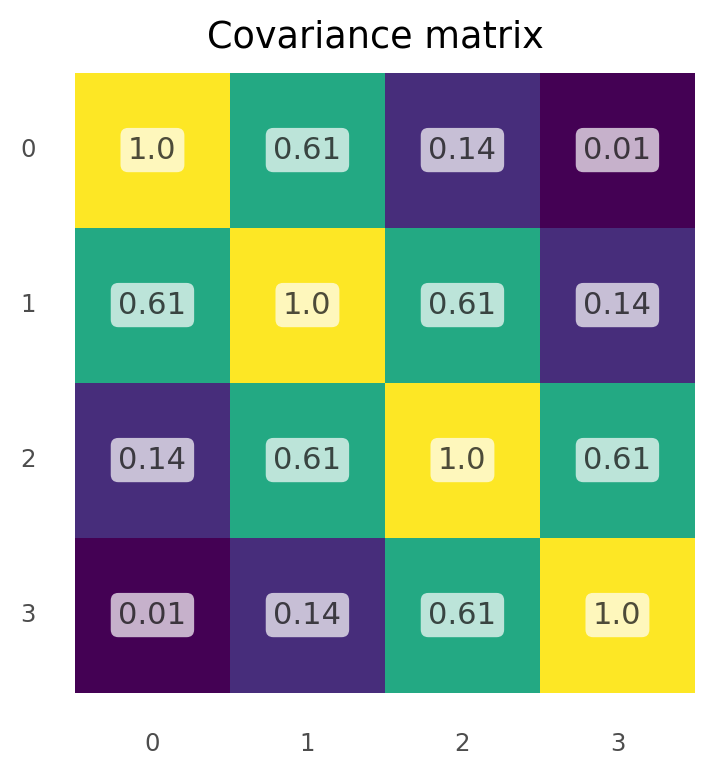

<ggplot: (8791713716899)>

In [5]:
def exp_quad_kernel(x, knots, l=1):
    return np.array([np.exp(-((x - k) ** 2) / (2 * l ** 2)) for k in knots])


x = np.arange(-1, 3)
cov = exp_quad_kernel(x, x, l=1)


def plot_covariance_matrix(cov_mat, figure_size=None):
    nrows = cov_mat.shape[0]
    cov_df = pd.DataFrame(cov_mat)
    cov_df["rows"] = np.arange(0, nrows)
    cov_df = cov_df.melt(id_vars="rows", var_name="cols", value_name="value")
    cov_df["rows"] = pd.Categorical(cov_df["rows"], ordered=True)
    cov_df["cols"] = pd.Categorical(
        cov_df["cols"], categories=np.flip(np.arange(0, nrows)), ordered=True
    )
    cov_df["labels"] = np.round(cov_df["value"], 2)
    return (
        gg.ggplot(cov_df, gg.aes(x="rows", y="cols"))
        + gg.geom_tile(gg.aes(fill="value"))
        + gg.geom_label(gg.aes(label="labels"), label_size=0, alpha=0.7)
        + gg.scale_x_discrete(expand=(0, 0.5, 0, 0.5))
        + gg.scale_y_discrete(expand=(0, 0.5, 0, 0.5))
        + gg.coord_equal()
        + gg.theme(
            figure_size=figure_size,
            axis_title=gg.element_blank(),
            legend_position="none",
        )
        + gg.labs(title="Covariance matrix")
    )


plot_covariance_matrix(cov, figure_size=(4, 4))

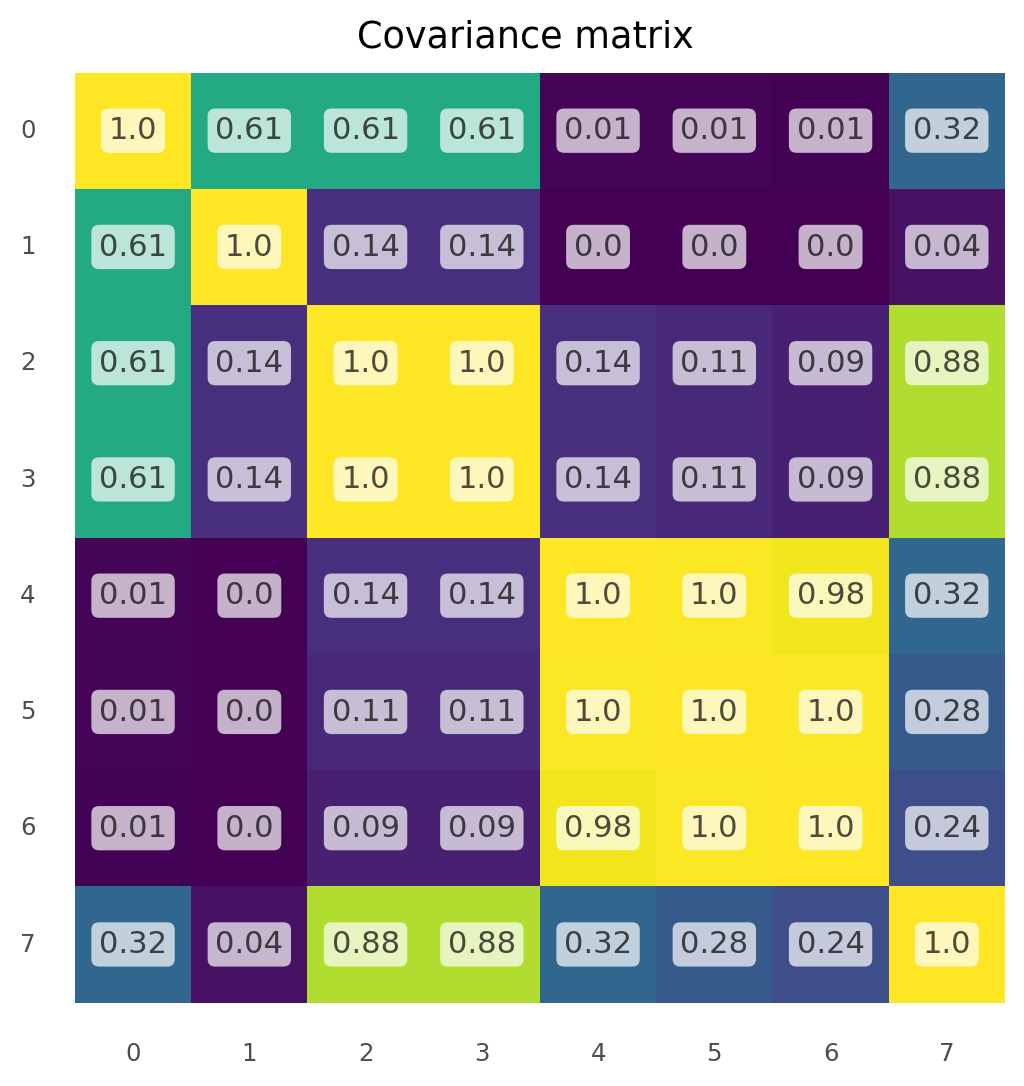

<ggplot: (8791713716941)>

In [6]:
x = np.array([-1, -2, 0, 0, 2, 2.1, 2.2, 0.5])
cov = exp_quad_kernel(x, x, l=1)
plot_covariance_matrix(cov, figure_size=(6, 6))

- so far have shown we can use multivarite normal distributions to model functions
- the following example uses the expoentiated quadratic kernel to define a covariance matrix of a multivariate normal and we use samples from the distribution to represent the functions
    - see the parameter $\ell$ controls the smoothness

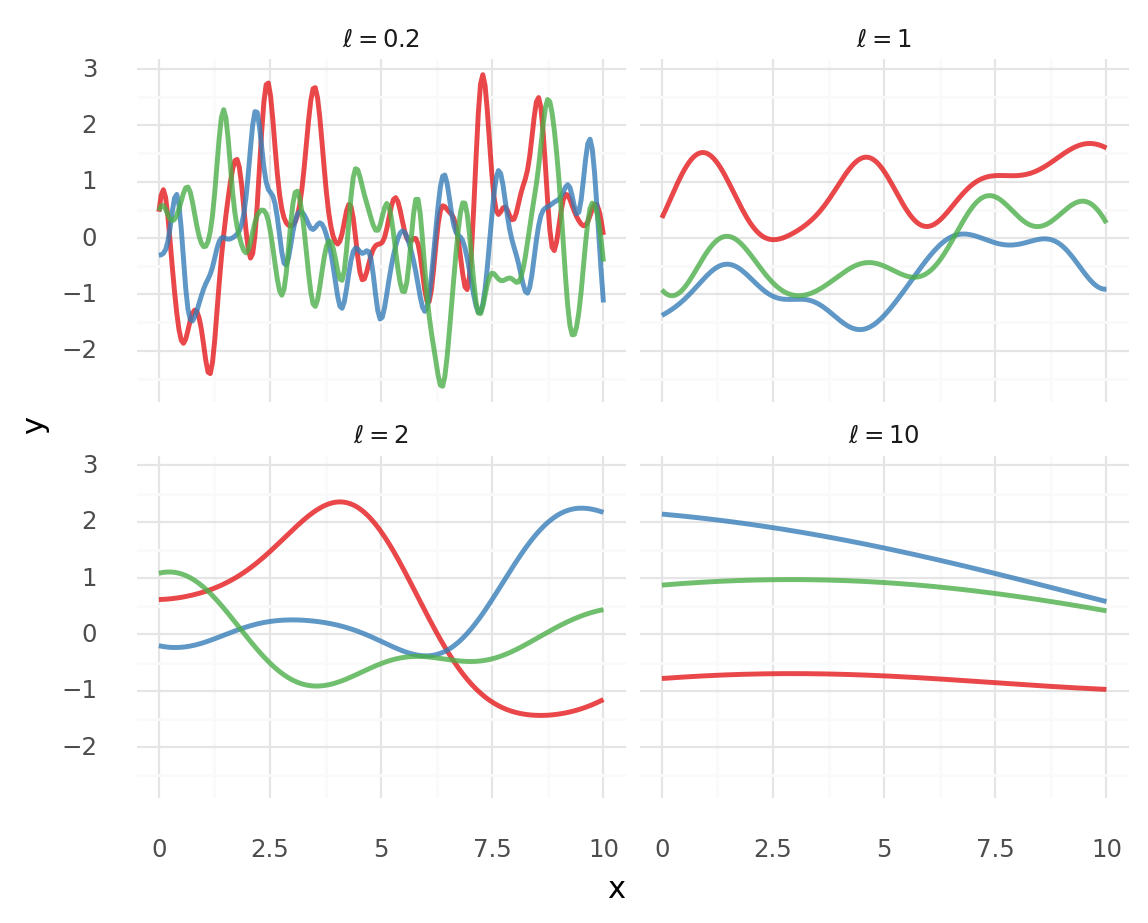

<ggplot: (8791722487227)>

In [7]:
np.random.seed(0)
x = np.linspace(0, 10, 200)

data = None
n_rvs = 3
l_order = []
for l in (0.2, 1, 2, 10):
    cov = exp_quad_kernel(x, x, l=l)
    y = stats.multivariate_normal.rvs(cov=cov, size=n_rvs).T
    d = {f"y{i}": y[:, i] for i in range(n_rvs)}
    d["x"] = x
    d["l"] = f"$\\ell = {l}$"
    l_order.append(d["l"])
    data = pd.concat([data, pd.DataFrame(d)])

data = data.melt(id_vars=["x", "l"], var_name="y_id", value_name="y")
data["l"] = pd.Categorical(data["l"], categories=l_order, ordered=True)

(
    gg.ggplot(data, gg.aes(x="x", y="y"))
    + gg.facet_wrap("l")
    + gg.geom_line(gg.aes(color="y_id"), size=1, alpha=0.8)
    + gg.scale_color_brewer(type="qual", palette="Set1")
    + gg.theme(legend_position="none")
)

### Gaussian processes

- definition from Wikipedia: "The collection of random variables indexed by time or space, such that every finite collection of those random variables has a multivariate normal distribution, i.e. every finite linear combination of them is normally distributed."
    - need not consider  the infinite mathematical object, instead marginalize over the observed data by reducing the dimensions to the number of data points we have
- GPs are useful for building Bayesian non-parametric models, as we can use them as prior distributions over functions

## Gaussian process regression

- model a value $y$ as a function $\mathcal{f}$ of $x$ with some noise $\epsilon$:

$$
y \sim \mathcal{N}(\mu = \mathcal{f}(x), \sigma=\epsilon) \quad \epsilon \sim \mathcal{N}(0, \sigma_\epsilon)
$$

- now add a prior distribution to $\mathcal{f}$ using a GP

$$
f(x) \sim \mathcal{GP}(\mu_x, K(x, x^\prime))
$$

- where:
    - $\mu_x$: mean function
    - $K(x, x^\prime)$: kernel or covariance function
- since the prior distribution of a GP is normal and the likelihood is normal, then the posterior is also a GP:

$$
p(f(X_*) | X_*, X, y) \sim \mathcal{N}(\mu, \Sigma) \\
\mu = K_*^T K^{-1} y \\
\Sigma = K_{**} - K_*^T K^{-1} K_*
$$

- where:
    - $K = K(X, X)$ 
    - $K_* = K(X_*, X)$ 
    - $K_{**} = K(X_*, X_*)$
    - $X$: observed data
    - $X_*$: test data points
- example with modeling a GP using PyMC3:
    - create some data folowing a sine curve

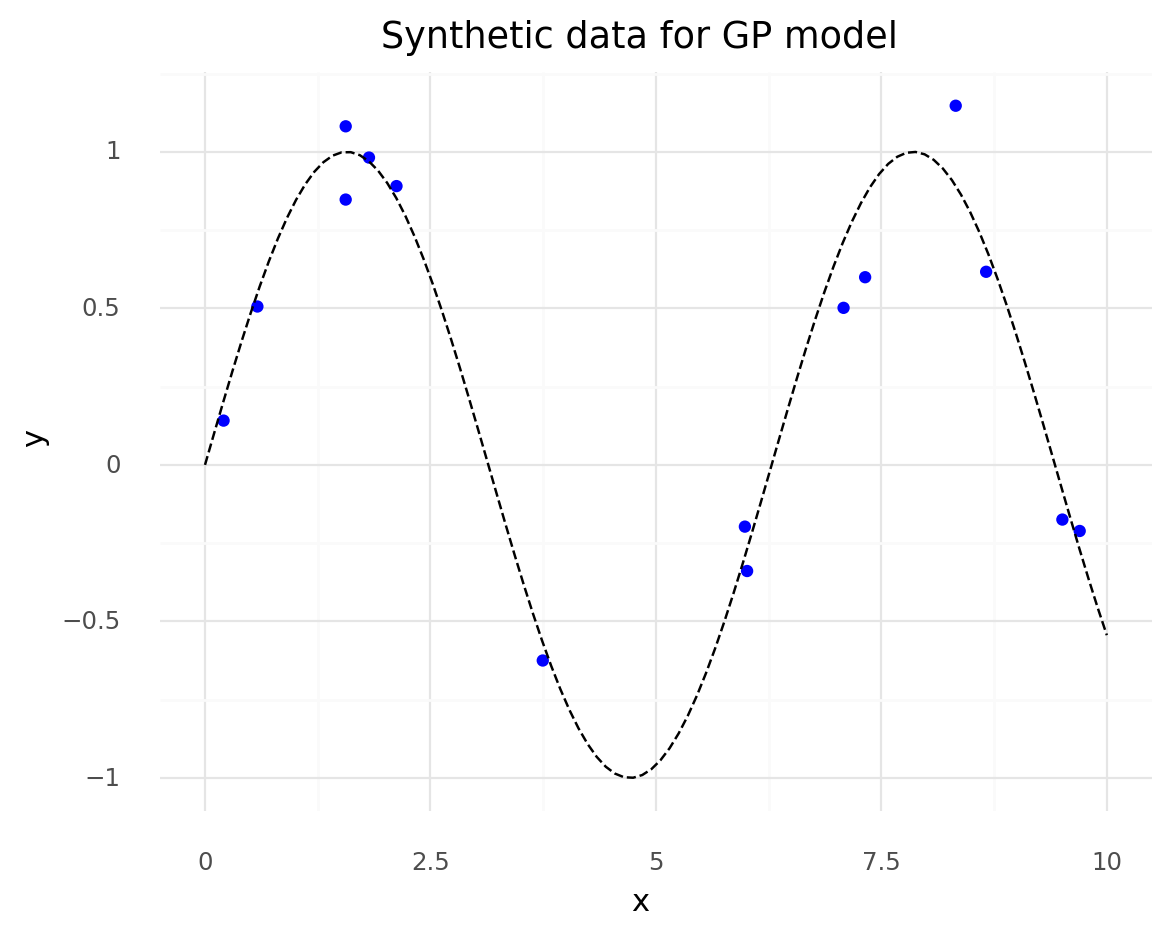

<ggplot: (8791722487321)>

In [8]:
np.random.seed(42)

x = np.random.uniform(0, 10, size=15)
y = np.random.normal(np.sin(x), 0.1)
d = pd.DataFrame({"x": x, "y": y})

x_true = np.linspace(0, 10, 100)
y_true = np.sin(x_true)
d_true = pd.DataFrame({"x": x_true, "y": y_true})

(
    gg.ggplot(d, gg.aes("x", "y"))
    + gg.geom_point(color="blue")
    + gg.geom_line(data=d_true, linetype="--")
    + gg.labs(title="Synthetic data for GP model")
)

- to model, need to find:
    - $\epsilon$: the variance of the normal likelihood
     - $\ell$: length-scale parameter of the kernel

In [9]:
X = x[:, None]

with pm.Model() as model_reg:
    # Hyperprior for length-scale kernel parameter.
    l = pm.Gamma("l", 2, 0.5)
    # Covariance function.
    cov = pm.gp.cov.ExpQuad(1, ls=l)
    # GP prior over f.
    gp = pm.gp.Marginal(cov_func=cov)
    # Prior for noise.
    epsilon = pm.HalfNormal("epsilon", 25)
    # Likelihood.
    y_pred = gp.marginal_likelihood("y_pred", X=X, y=y, noise=epsilon)
    # Sample.
    trace_reg = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, l]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 37 seconds.


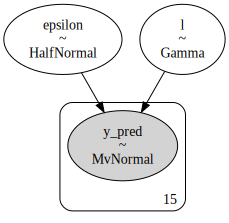

In [10]:
pm.model_to_graphviz(model_reg)

/usr/local/Caskroom/miniconda/base/envs/bayesian-analysis-with-python_e2/lib/python3.9/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.


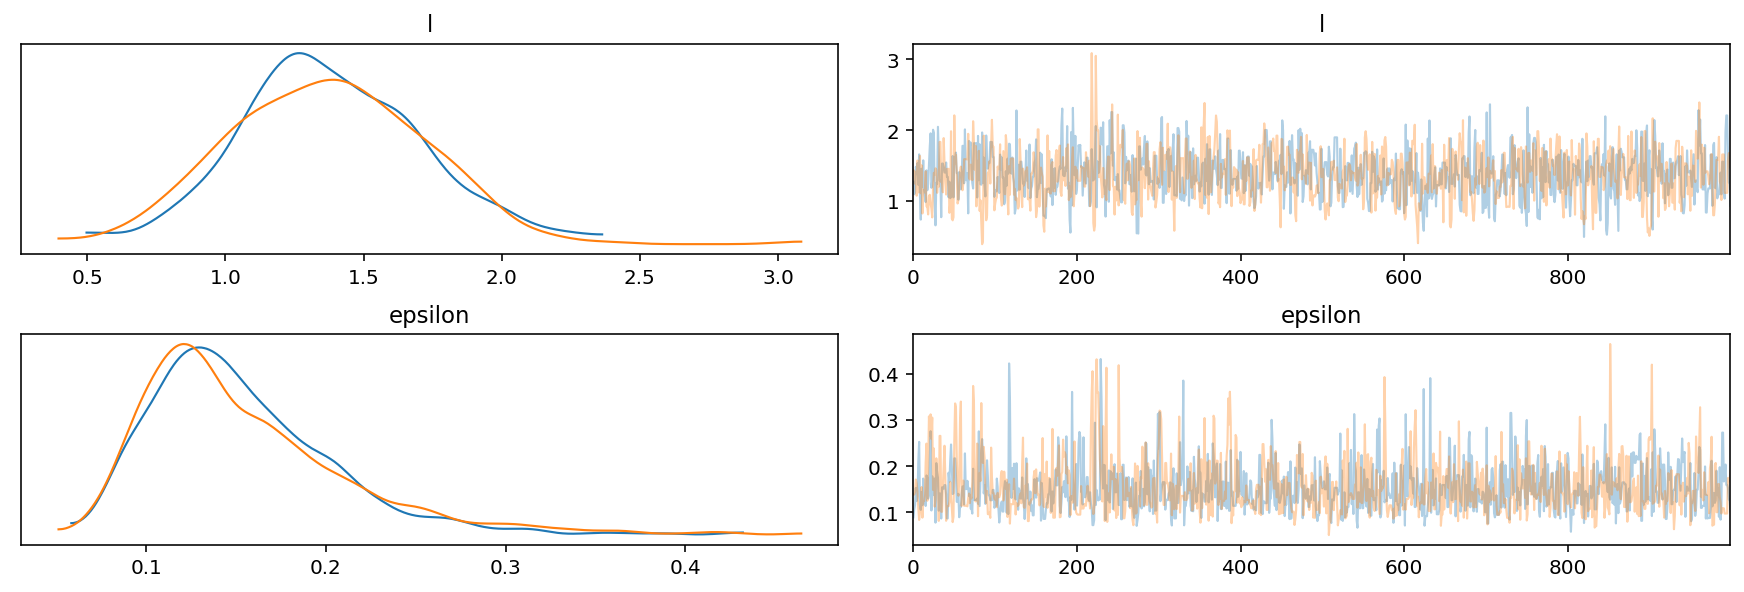

In [11]:
az.plot_trace(trace_reg)
plt.show()

- can get samples from the GP posterior by computing the conditional distribution evaluated over new input locations

In [12]:
X_new = np.linspace(np.floor(x.min()), np.ceil(x.max()), 100)[:, None]

with model_reg:
    f_pred = gp.conditional("f_pred", X_new)
    pred_samples = pm.sample_posterior_predictive(trace_reg, vars=[f_pred], samples=200)

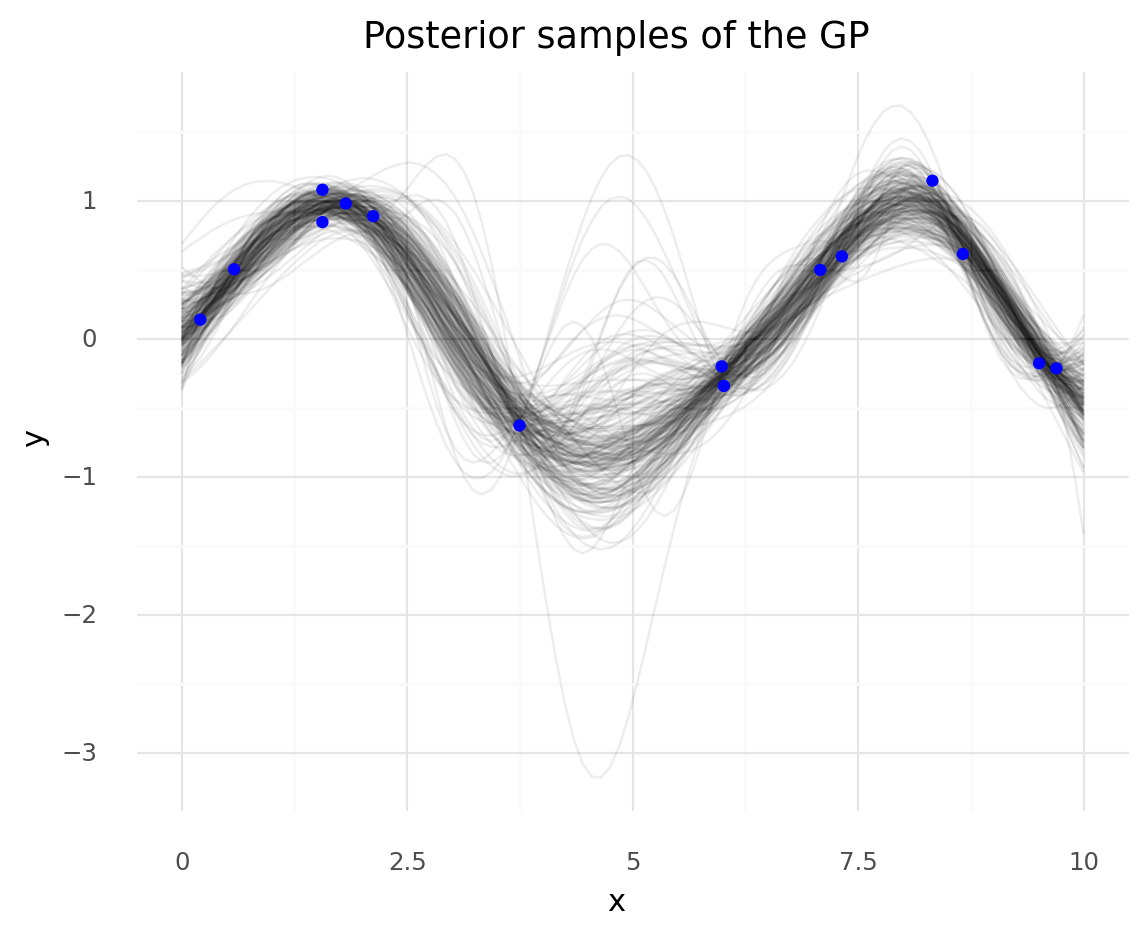

<ggplot: (8791721385981)>

In [13]:
gp_post = pd.DataFrame(pred_samples["f_pred"].T)
gp_post["x"] = X_new[:, 0]
gp_post = gp_post.melt(id_vars="x", var_name="sample_idx", value_name="y")
(
    gg.ggplot(gp_post, gg.aes(x="x", y="y"))
    + gg.geom_line(gg.aes(group="sample_idx"), alpha=0.07)
    + gg.geom_point(data=d, color="blue")
    + gg.labs(title="Posterior samples of the GP")
)

- can compute the mean vector and standard deviation of the conditional distribution at each point in the parameter space
    - use the mean values for $\ell$ and $\epsilon$

In [14]:
point = {"l": trace_reg["l"].mean(), "epsilon": trace_reg["epsilon"].mean()}
point

{'l': 1.3755161852833542, 'epsilon': 0.15409951350806478}

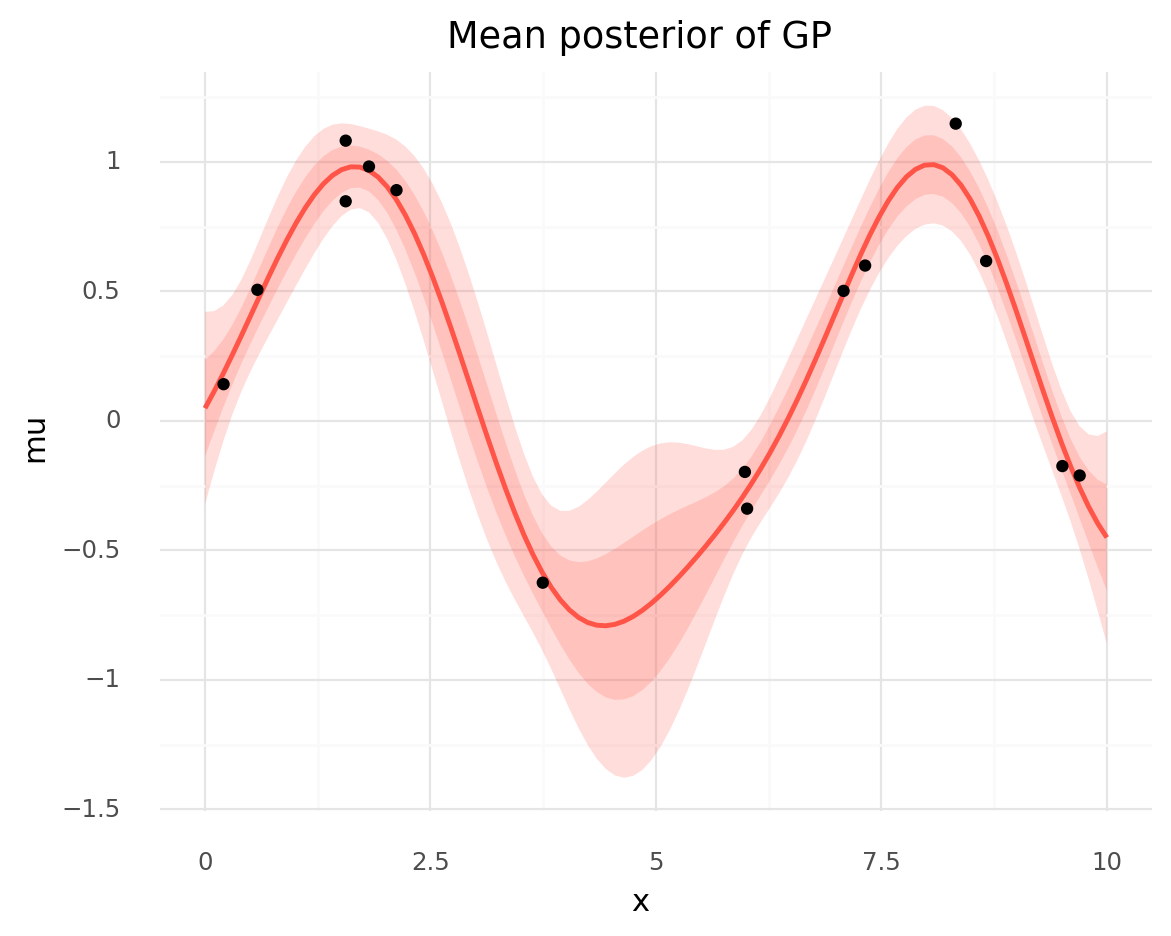

<ggplot: (8791721350855)>

In [15]:
mu, var = gp.predict(X_new, point=point, diag=True)
sd = var ** 0.5
gp_post2 = pd.DataFrame(
    {
        "x": X_new.flatten(),
        "mu": mu,
        "sd_low": mu - sd,
        "sd_high": mu + sd,
        "2sd_low": mu - 2 * sd,
        "2sd_high": mu + 2 * sd,
    }
)

color = "#FF5548"

(
    gg.ggplot(gp_post2, gg.aes(x="x"))
    + gg.geom_ribbon(gg.aes(ymin="2sd_low", ymax="2sd_high"), alpha=0.2, fill=color)
    + gg.geom_ribbon(gg.aes(ymin="sd_low", ymax="sd_high"), alpha=0.2, fill=color)
    + gg.geom_line(gg.aes(y="mu"), color=color, size=1)
    + gg.geom_point(gg.aes(y="y"), data=d)
    + gg.labs(title="Mean posterior of GP")
)

- can use non-Gaussian likelihoods and inverse functions to generalize GPs (discussed next)
    - however, these are not analytically tractable like the Gaussian example above

## Regression with spatial autocorrelation

- example: (taken from *Statistical Rethinking*)
    - 10 different island-societies
    - for each island, we have the number of tools they use
    - we believe larger populations thrive because they develop and keep more tools
    - another factor could be contact rates
- model the number of tools as a Poisson distribution of the population size
    - use lagarithm of population size to focus on the magnitudes
    - use distance as a proxy for contact rate

In [16]:
# Distances between islands.
islands_dist = pd.read_csv(data_path / "islands_dist.csv", index_col=0)
islands_dist.round(1)

,Ml,Ti,SC,Ya,Fi,Tr,Ch,Mn,To,Ha
Malekula,0.0,0.5,0.6,4.4,1.2,2.0,3.2,2.8,1.9,5.7
Tikopia,0.5,0.0,0.3,4.2,1.2,2.0,2.9,2.7,2.0,5.3
Santa Cruz,0.6,0.3,0.0,3.9,1.6,1.7,2.6,2.4,2.3,5.4
Yap,4.4,4.2,3.9,0.0,5.4,2.5,1.6,1.6,6.1,7.2
Lau Fiji,1.2,1.2,1.6,5.4,0.0,3.2,4.0,3.9,0.8,4.9
Trobriand,2.0,2.0,1.7,2.5,3.2,0.0,1.8,0.8,3.9,6.7
Chuuk,3.2,2.9,2.6,1.6,4.0,1.8,0.0,1.2,4.8,5.8
Manus,2.8,2.7,2.4,1.6,3.9,0.8,1.2,0.0,4.6,6.7
Tonga,1.9,2.0,2.3,6.1,0.8,3.9,4.8,4.6,0.0,5.0
Hawaii,5.7,5.3,5.4,7.2,4.9,6.7,5.8,6.7,5.0,0.0


In [17]:
# Data about island-societies.
islands = pd.read_csv(data_path / "islands.csv")
islands.round(1)

,culture,population,contact,total_tools,mean_TU,lat,lon,lon2,logpop
0,Malekula,1100,low,13,3.2,-16.3,167.5,-12.5,7.0
1,Tikopia,1500,low,22,4.7,-12.3,168.8,-11.2,7.3
2,Santa Cruz,3600,low,24,4.0,-10.7,166.0,-14.0,8.2
3,Yap,4791,high,43,5.0,9.5,138.1,-41.9,8.5
4,Lau Fiji,7400,high,33,5.0,-17.7,178.1,-1.9,8.9
5,Trobriand,8000,high,19,4.0,-8.7,150.9,-29.1,9.0
6,Chuuk,9200,high,40,3.8,7.4,151.6,-28.4,9.1
7,Manus,13000,low,28,6.6,-2.1,146.9,-33.1,9.5
8,Tonga,17500,high,55,5.4,-21.2,-175.2,4.8,9.8
9,Hawaii,275000,low,71,6.6,19.9,-155.6,24.4,12.5


In [18]:
islands_dist_sqr = islands_dist.values ** 2
culture_labels = islands.culture.values
index = islands.index.values
log_pop = islands.logpop
total_tools = islands.total_tools
x_data = [islands.lat.values[:, None], islands.lon.values[:, None]]

- model to build (ignoring the standard hyperpriors, etc):

$$
y \sim \text{Poisson}(\mu) \\
\mu \sim \exp(\alpha + \beta x + \mathcal{f}) \\
\mathcal{f} \sim \mathcal{GP}([0, \dots, 0], K(x, x^\prime)
$$

- same as a Possion regression GLM but the terms in the linear model $\mathcal{f}$ come from a GP
    - use the island distances to compute the kernel
        - incorporates a measure of similarity between the data points

In [19]:
with pm.Model() as model_islands:
    eta = pm.HalfCauchy("eta", 1)
    l = pm.HalfCauchy("l", 1)

    cov = eta * pm.gp.cov.ExpQuad(1, ls=l)
    gp = pm.gp.Latent(cov_func=cov)
    f = gp.prior("f", X=islands_dist_sqr)

    alpha = pm.Normal("alpha", 0, 10)
    beta = pm.Normal("beta", 0, 1)
    mu = pm.math.exp(alpha + f[index] + beta * log_pop)
    tt_pred = pm.Poisson("tt_pred", mu, observed=total_tools)

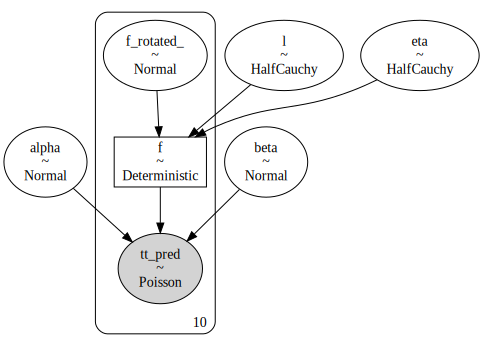

In [20]:
pm.model_to_graphviz(model_islands)

In [21]:
with model_islands:
    trace_islands = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta, alpha, f_rotated_, l, eta]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 216 seconds.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8977309206438002, but should be close to 0.8. Try to increase the number of tuning steps.
There were 26 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.


- plot some samples of the posterior distribution of covariance functions in terms of distances
    - the covariance is not very high on average and drops to 0 around 2,000 km
    - the samples are quite varying showing there is a lot of uncertainty in the estimate of covariance

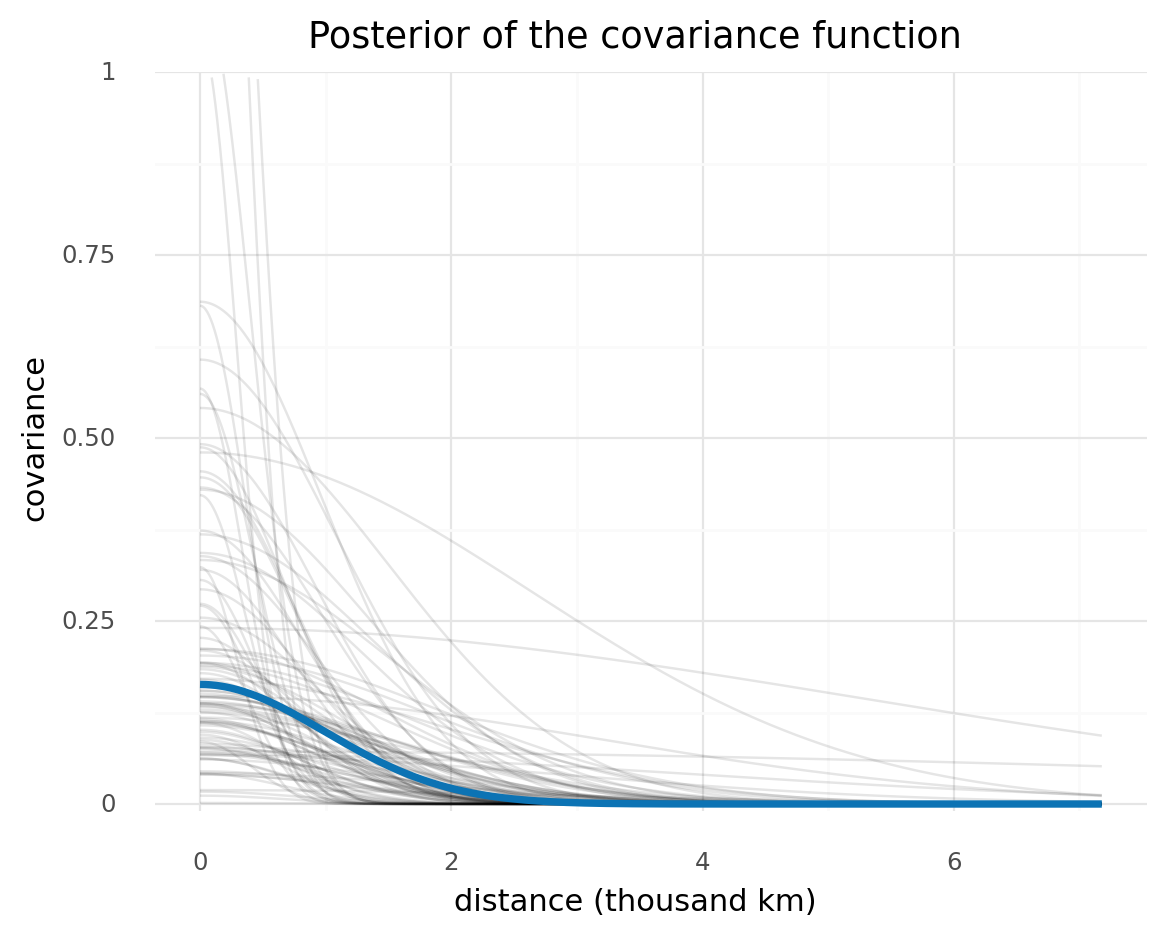

<ggplot: (8791695720789)>

In [22]:
trace_eta = trace_islands["eta"]
trace_l = trace_islands["l"]

xrange = np.linspace(0, islands_dist.values.max(), 1000)

islands_post_summary = pd.DataFrame(
    {"x": xrange, "y": np.median(trace_eta) * np.exp(-np.median(trace_l) * xrange ** 2)}
)

islands_post_df = pd.DataFrame(
    (trace_eta[::20][:, None] * np.exp(-trace_l[::20][:, None] * xrange ** 2)).T
)
islands_post_df["x"] = xrange
islands_post_df = islands_post_df.melt(
    id_vars="x", var_name="sample_idx", value_name="y"
)
(
    gg.ggplot(islands_post_summary, gg.aes("x", "y"))
    + gg.geom_line(gg.aes(group="sample_idx"), data=islands_post_df, alpha=0.1)
    + gg.geom_line(color="#0C73B4", size=1.5)
    + gg.scale_y_continuous(expand=(0, 0.01, 0, 0), limits=(0, 1))
    + gg.labs(
        x="distance (thousand km)",
        y="covariance",
        title="Posterior of the covariance function",
    )
)

- explore how strong the islands are correlated according to the model
- turn the covariance matrix into a correlation matrix

In [23]:
# Compute posterior median covariance among societies.
sigma = np.median(trace_eta) * (np.exp(-np.median(trace_l) * islands_dist_sqr))
# Convert to correlation matrix.
sigma_post = np.diag(np.diag(sigma) ** (-0.5))
rho = sigma_post @ sigma @ sigma_post
rho = pd.DataFrame(rho, index=islands_dist.columns, columns=islands_dist.columns)
rho.round(2)

,Ml,Ti,SC,Ya,Fi,Tr,Ch,Mn,To,Ha
Ml,1.00,0.89,0.82,0.00,0.46,0.12,0.01,0.02,0.17,0.0
Ti,0.89,1.00,0.95,0.00,0.46,0.13,0.01,0.03,0.14,0.0
SC,0.82,0.95,1.00,0.00,0.29,0.23,0.03,0.06,0.07,0.0
Ya,0.00,0.00,0.00,1.00,0.00,0.05,0.29,0.27,0.00,0.0
Fi,0.46,0.46,0.29,0.00,1.00,0.01,0.00,0.00,0.74,0.0
Tr,0.12,0.13,0.23,0.05,0.01,1.00,0.19,0.69,0.00,0.0
Ch,0.01,0.01,0.03,0.29,0.00,0.19,1.00,0.47,0.00,0.0
Mn,0.02,0.03,0.06,0.27,0.00,0.69,0.47,1.00,0.00,0.0
To,0.17,0.14,0.07,0.00,0.74,0.00,0.00,0.00,1.00,0.0
Ha,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.0


- can plot the correlation network on the geographical locations of the islands

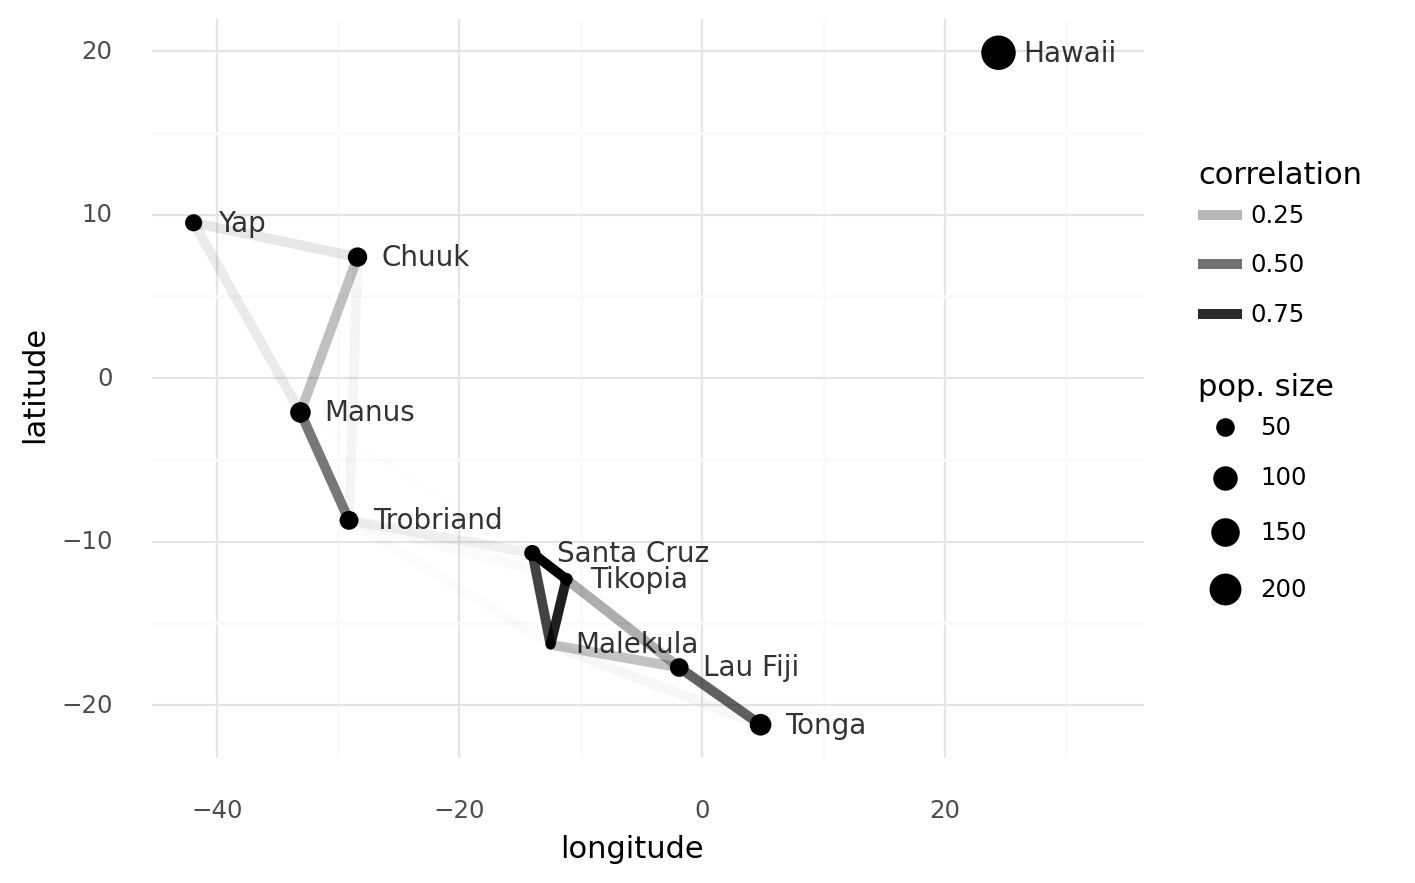

<ggplot: (8791693743900)>

In [24]:
logpop = np.copy(log_pop) / np.max(log_pop)
psize = np.exp(logpop * 5.5)
log_pop_seq = np.linspace(6, 14, 100)
lambda_post = np.exp(
    trace_islands["alpha"][:, None] + trace_islands["beta"][:, None] * log_pop_seq
)

plot_data = pd.DataFrame(
    {
        "lon2": islands.lon2,
        "lat": islands.lat,
        "pop_size": psize,
        "island": culture_labels,
    }
)

network_data = {
    "island1": [],
    "island2": [],
    "lon1": [],
    "lon2": [],
    "lat1": [],
    "lat2": [],
    "corr": [],
}
for i in range(10):
    for j in range(i + 1, 10):
        network_data["island1"] += [islands.culture[i]]
        network_data["island2"] += [islands.culture[j]]
        network_data["lon1"] += [islands.lon2[i]]
        network_data["lat1"] += [islands.lat[i]]
        network_data["lon2"] += [islands.lon2[j]]
        network_data["lat2"] += [islands.lat[j]]
        network_data["corr"] += [rho.iloc[i, j] ** 2]

network_data = pd.DataFrame(network_data)

(
    gg.ggplot(plot_data, gg.aes(x="lon2", y="lat"))
    + gg.geom_segment(
        gg.aes(x="lon1", xend="lon2", y="lat1", yend="lat2", alpha="corr"),
        data=network_data,
        size=2,
    )
    + gg.geom_text(gg.aes(label="island"), nudge_x=2, ha="left", alpha=0.8, size=10)
    + gg.geom_point(gg.aes(size="psize"))
    + gg.scale_x_continuous(expand=(0.05, 0, 0, 10))
    + gg.scale_alpha_continuous(range=(0, 1))
    + gg.labs(x="longitude", y="latitude", size="pop. size", alpha="correlation")
)

## Gaussian process classification

- can turn a linear model into a classifier by using a Bernoulli likelihood with a logisitic inverse link function and applying a boundary decision rule
    - example with Iris data set

In [25]:
iris = pd.read_csv(data_path / "iris.csv")
iris.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


- begin with binary classification - setosa vs. versicolor - using a single independent variable - sepal length

In [26]:
df = iris.query("species == ('setosa', 'versicolor')")
data_y = pd.Categorical(df["species"]).codes
x_1 = df["sepal_length"].values
X_1 = x_1[:, None]

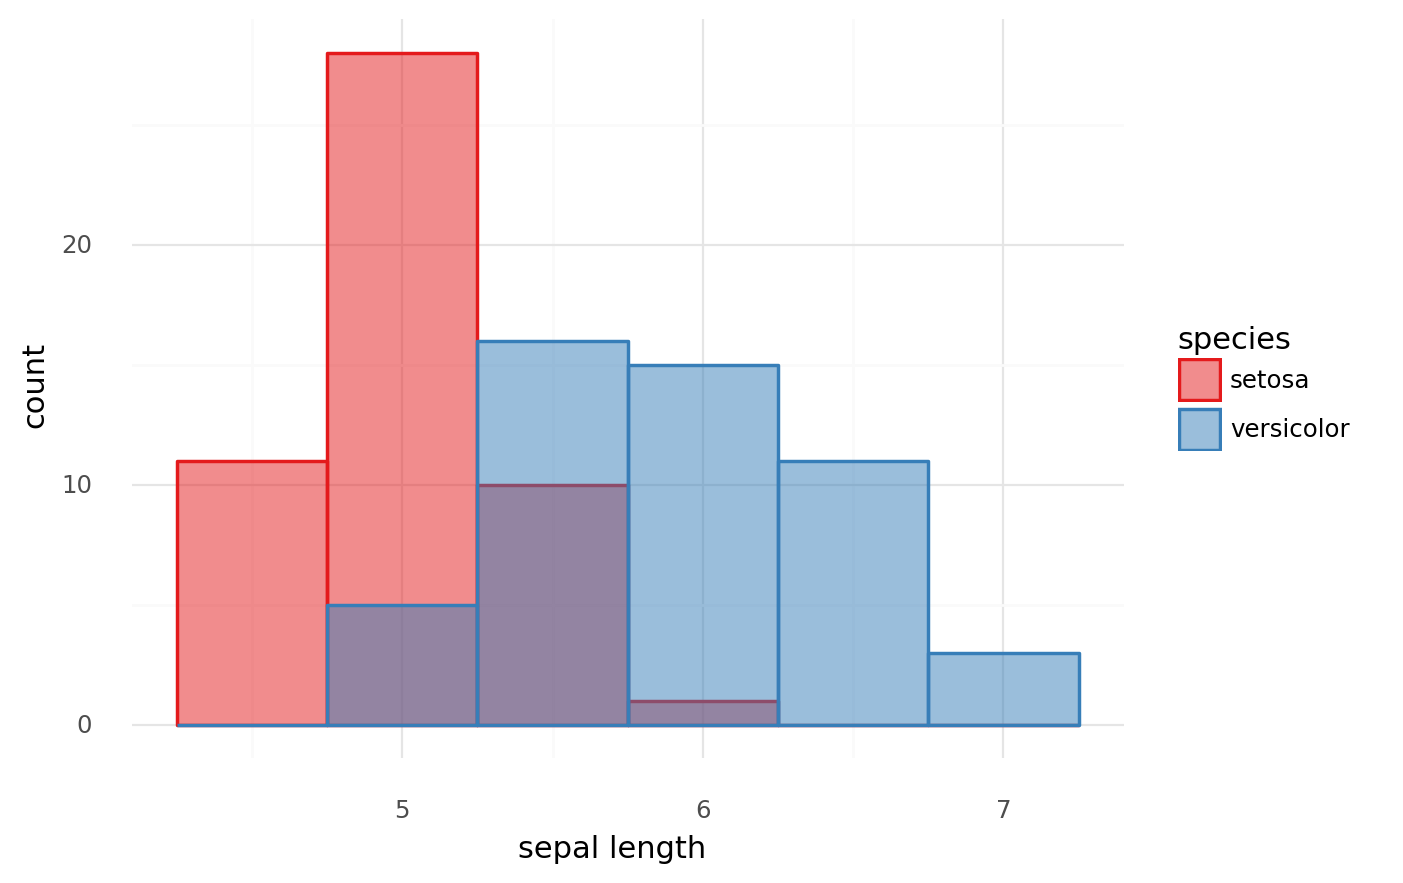

<ggplot: (8791694021114)>

In [27]:
(
    gg.ggplot(df, gg.aes(x="sepal_length", color="species", fill="species"))
    + gg.geom_histogram(alpha=0.5, size=0.7, binwidth=0.5, position="identity")
    + gg.scale_color_brewer(type="qual", palette="Set1")
    + gg.scale_fill_brewer(type="qual", palette="Set1")
    + gg.labs(x="sepal length", y="count", color="species", fill="species")
)

- use `pm.gp.Latent()` instead of `pm.gp.Marginal()` becuase it is more general
    - `pm.gp.Marginal()` is only for Gaussian likelihoods where it is more efficient by doing more analytical solving of the GP

In [28]:
with pm.Model() as model_iris:
    l = pm.Gamma("l", 2, 0.5)
    cov = pm.gp.cov.ExpQuad(1, l)
    gp = pm.gp.Latent(cov_func=cov)
    f = gp.prior("f", X=X_1)
    y = pm.Bernoulli("y", p=pm.math.sigmoid(f), observed=data_y)
    trace_iris = pm.sample(1000, chains=1, compute_convergence_checks=False)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [f_rotated_, l]


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 70 seconds.


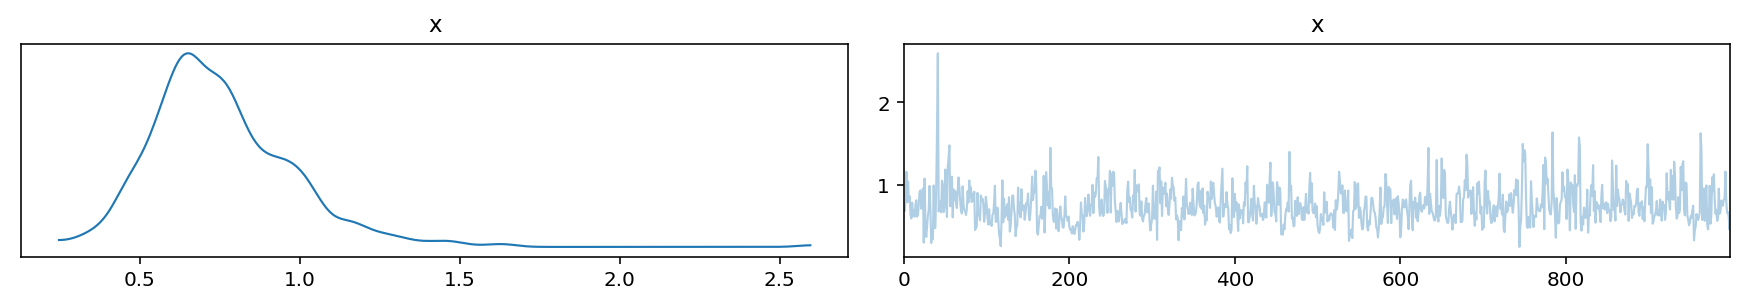

In [29]:
az.plot_trace(trace_iris["l"])
plt.show()

- want to sample from GP posterior
    - compute the *conditional* distribution evaluated over new input locations

In [30]:
X_new = np.linspace(np.floor(x_1.min()), np.ceil(x_1.max()), 200)[:, None]
with model_iris:
    f_pred = gp.conditional("f_pred", X_new)
    pred_samples = pm.sample_posterior_predictive(
        trace_iris, vars=[f_pred], samples=1000
    )

/usr/local/Caskroom/miniconda/base/envs/bayesian-analysis-with-python_e2/lib/python3.9/site-packages/arviz/stats/stats.py:484: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions


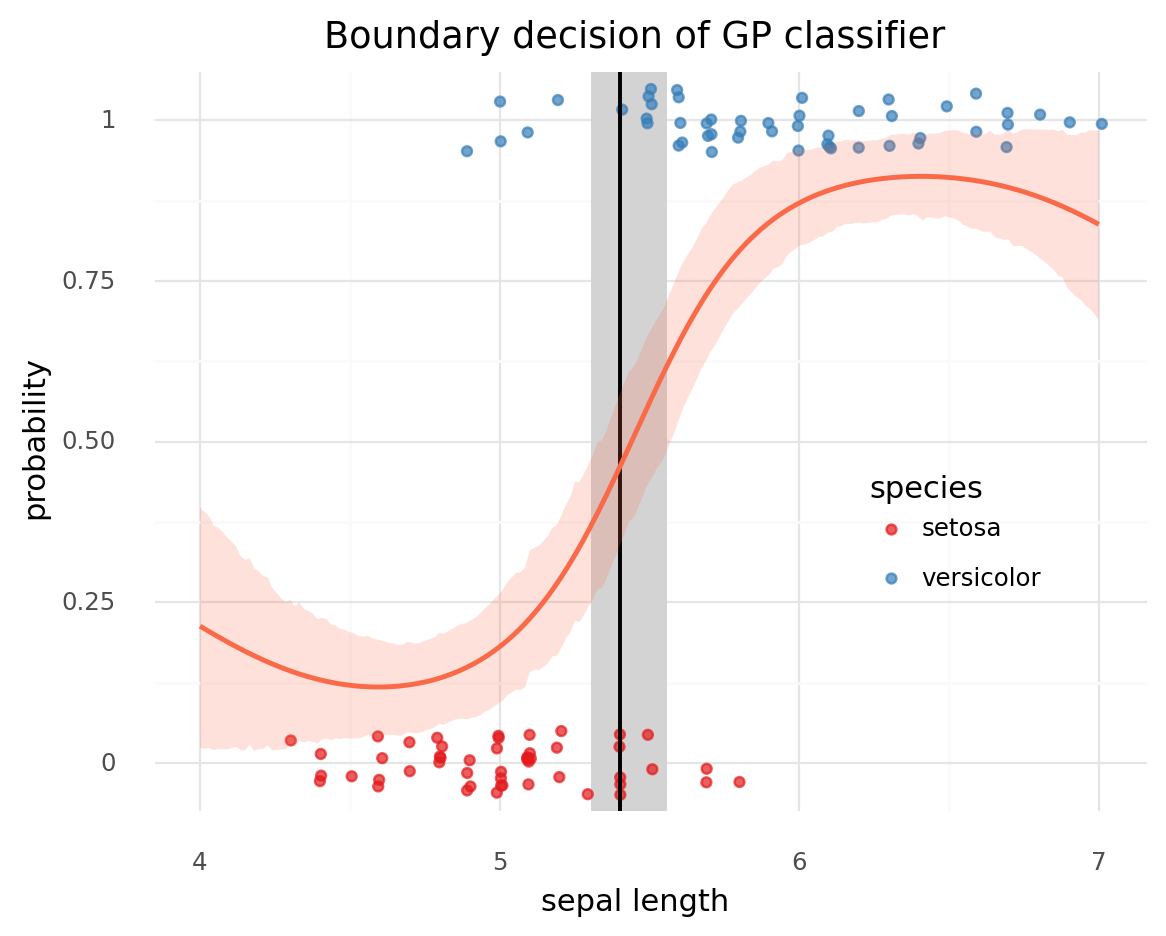

<ggplot: (8791695996151)>

In [31]:
def find_midpoint(a1, a2, value):
    a1 = np.asarray(a1)
    idx0 = np.argsort(np.abs(a1 - value))[0]
    idx1 = idx0 - 1 if a1[idx0] > value else idx0 + 1
    if idx1 == len(a1):
        idx1 -= 1
    return (a2[idx0] + a2[idx1]) / 2.0


def logistic(x):
    return 1.0 / (1.0 + np.exp(-x))


def make_f_pred_post_df(fp, x):
    fp_mean = np.mean(fp, 0)
    if np.any(np.isnan(fp)):
        raise Exception("Found `nan` in samples - don't know why, just sample again.")

    # HDI of predicited function `f`.
    fp_hdi = pd.DataFrame(az.hdi(fp, hdi_prob=0.89), columns=["hdi_low", "hdi_high"])
    fp_hdi["x"] = x
    fp_hdi["mean"] = fp_mean
    return fp_hdi


def make_decision_boundary_df(fp):
    decision_boundaries = np.array([find_midpoint(f, X_new[:, 0], 0.5) for f in fp])
    decision_boundary = decision_boundaries.mean()
    decision_boundary_hdi = az.hdi(decision_boundaries, hdi_prob=0.89)
    return decision_boundary, decision_boundary_hdi


# Get predicted functions `f`.
fp = logistic(pred_samples["f_pred"])
fp_hdi = make_f_pred_post_df(fp, x=X_new.flatten())

# Find decision bounadry HDI
decision_boundary, decision_boundary_hdi = make_decision_boundary_df(fp)


def plot_iris_classifier(iris_x, iris_y, iris_species, fp_df, db, db_hdi):
    iris_plot_df = pd.DataFrame({"x": iris_x, "y": iris_y, "species": iris_species})
    jitter_height = 0.05
    box_height_scale = 1.5
    ymax = 1 + box_height_scale * jitter_height
    ymin = 0 - box_height_scale * jitter_height

    return (
        gg.ggplot(iris_plot_df)
        + gg.geom_rect(
            xmin=db_hdi[0],
            xmax=db_hdi[1],
            ymin=ymin,
            ymax=ymax,
            alpha=0.2,
            fill="lightgray",
        )
        + gg.geom_jitter(
            gg.aes("x", "y", color="species"),
            width=0.01,
            height=jitter_height,
            alpha=0.7,
        )
        + gg.geom_vline(xintercept=db, size=0.8)
        + gg.geom_ribbon(
            gg.aes("x", ymin="hdi_low", ymax="hdi_high"),
            data=fp_df,
            alpha=0.2,
            fill="#FA6A48",
        )
        + gg.geom_line(gg.aes("x", "mean"), data=fp_df, color="#FA6A48", size=1)
        + gg.scale_y_continuous(limits=(ymin, ymax), expand=(0, 0))
        + gg.scale_color_brewer(type="qual", palette="Set1")
        + gg.theme(legend_position=(0.75, 0.4))
        + gg.labs(
            x="sepal length",
            y="probability",
            title="Boundary decision of GP classifier",
        )
    )


plot_iris_classifier(
    iris_x=df["sepal_length"],
    iris_y=data_y,
    iris_species=df["species"],
    fp_df=fp_hdi,
    db=decision_boundary,
    db_hdi=decision_boundary_hdi,
)

- the tails of the predicted covariance function revert towards the prior because there is no data
    - if we are only concerned with the decision boundary, then this is not a problem
    - can fix this by adding more structure to the GP by combining multiple covariance functions
    - change model to use 3 covariance kernels:
        - the linear kernel fixes the tail issue
        - the whitenoise is a computational trick to *stabilze* the computation of the cov. matrix

$$
\Sigma = K_{\text{ExpQuad}} + K_{\text{Linear}} + K_{\text{whitenoise}}(10^{-5})
$$

In [32]:
with pm.Model() as model_iris2:
    # Hyper priors.
    l = pm.Gamma("l", 2, 0.5)
    c = pm.Normal("c", x_1.min())
    tau = pm.HalfNormal("tau", 5)
    # Build multi-kernel covariance function.
    cov = pm.gp.cov.ExpQuad(1, l) + pm.gp.cov.Linear(1, c) + pm.gp.cov.WhiteNoise(1e-5)
    # GP prior.
    gp = pm.gp.Latent(cov_func=cov)
    f = gp.prior("f", X=X_1)
    # Likelihood
    y = pm.Bernoulli("y", p=pm.math.sigmoid(f), observed=data_y)

    # Sample.
    trace_iris2 = pm.sample(1000, chains=1, compute_convergence_checks=False)

    # Predict on new data
    f_pred = gp.conditional("f_pred", X_new)
    pred_samples = pm.sample_posterior_predictive(
        trace_iris2, vars=[f_pred], samples=1000
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [f_rotated_, tau, c, l]


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 106 seconds.
There were 38 divergences after tuning. Increase `target_accept` or reparameterize.


/usr/local/Caskroom/miniconda/base/envs/bayesian-analysis-with-python_e2/lib/python3.9/site-packages/arviz/stats/stats.py:484: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions


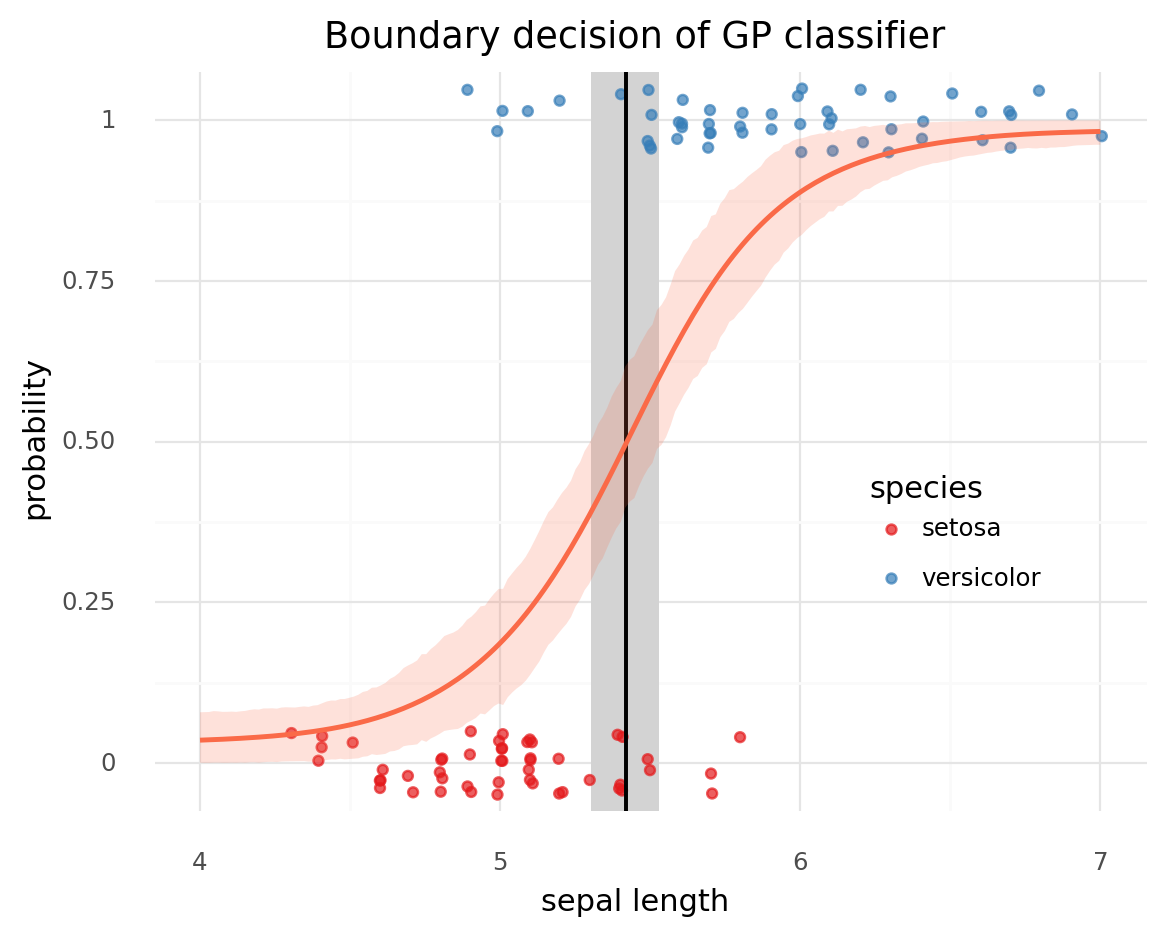

<ggplot: (8791694991382)>

In [33]:
# Get predicted functions `f`.
fp = logistic(pred_samples["f_pred"])
fp_hdi = make_f_pred_post_df(fp, x=X_new.flatten())

# Find decision bounadry HDI
decision_boundary, decision_boundary_hdi = make_decision_boundary_df(fp)

plot_iris_classifier(
    iris_x=df["sepal_length"],
    iris_y=data_y,
    iris_species=df["species"],
    fp_df=fp_hdi,
    db=decision_boundary,
    db_hdi=decision_boundary_hdi,
)

- in practice, would not need a GP for a simple logistic regression; instead use when need more flexibility
    - example modeling the probability of getting sick as a function of age:
        - the old and young are at higher risk of being sick than ages in between
        - model with example flu data

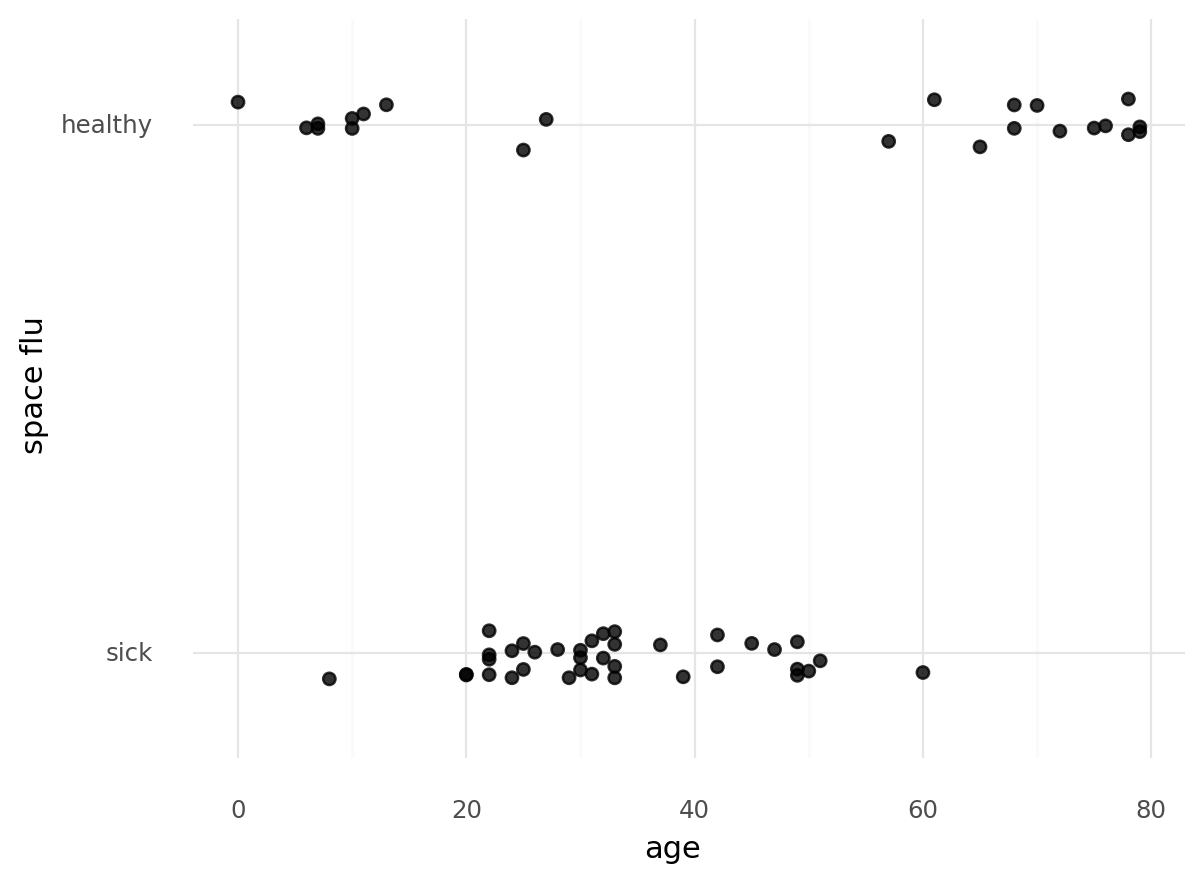

<ggplot: (8791698269097)>

In [34]:
df_sf = pd.read_csv(data_path / "space_flu.csv")
age = df_sf.age.values[:, None]
space_flu = df_sf.space_flu

(
    gg.ggplot(df_sf, gg.aes("age", "factor(space_flu)"))
    + gg.geom_jitter(width=0, height=0.05, alpha=0.8, size=2)
    + gg.scale_y_discrete(labels=("sick", "healthy"), expand=(0.1, 0.1))
    + gg.labs(x="age", y="space flu")
)

In [35]:
X_new = np.linspace(0, 80, 200)[:, None]

with pm.Model() as model_space_flu:
    l = pm.HalfCauchy("l", 1)
    cov = pm.gp.cov.ExpQuad(1, l) + pm.gp.cov.WhiteNoise(1e-5)
    gp = pm.gp.Latent(cov_func=cov)
    f = gp.prior("f", X=age)
    y = pm.Bernoulli("y", p=pm.math.sigmoid(f), observed=df_sf.space_flu)
    trace_space_flu = pm.sample(
        1000, tune=1000, chains=2, compute_convergence_checks=False
    )

    # Predictions on new data.
    f_pred = gp.conditional("f_pred", X_new)
    pred_samples = pm.sample_posterior_predictive(
        trace_space_flu, vars=[f_pred], samples=1000
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [f_rotated_, l]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 65 seconds.


/usr/local/Caskroom/miniconda/base/envs/bayesian-analysis-with-python_e2/lib/python3.9/site-packages/arviz/stats/stats.py:484: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions


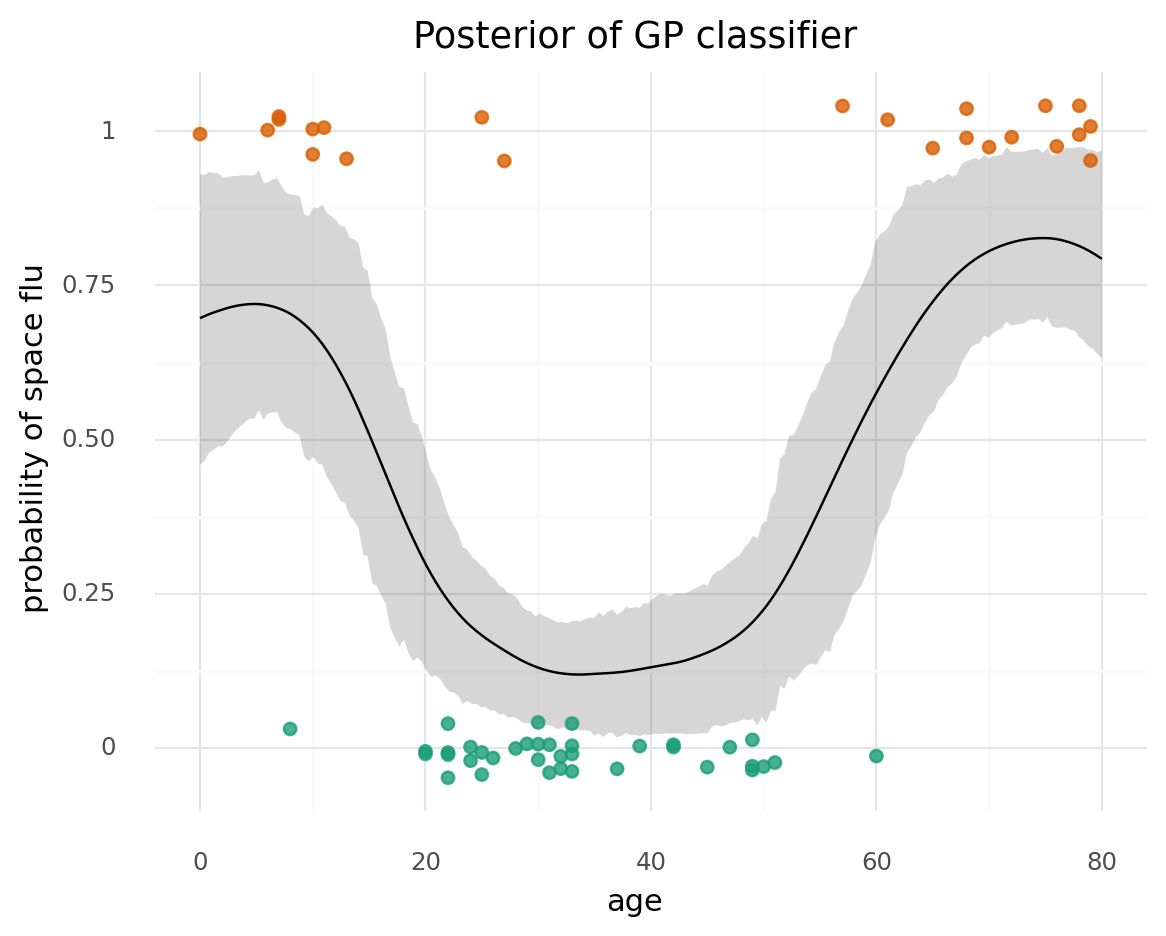

<ggplot: (8791700652213)>

In [36]:
fp = logistic(pred_samples["f_pred"])
fp_df = make_f_pred_post_df(fp, x=X_new.flatten())

(
    gg.ggplot(df_sf)
    + gg.geom_ribbon(
        gg.aes(x="x", ymin="hdi_low", ymax="hdi_high"), data=fp_df, alpha=0.2
    )
    + gg.geom_line(gg.aes(x="x", y="mean"), data=fp_df)
    + gg.geom_jitter(
        gg.aes("age", "space_flu", color="factor(space_flu)"),
        width=0,
        height=0.05,
        alpha=0.8,
        size=2,
    )
    + gg.scale_color_brewer(type="qual", palette="Dark2", guide=None)
    + gg.labs(x="age", y="probability of space flu", title="Posterior of GP classifier")
)

## Cox processes

- return to modeling count data using a Poisson likelihood with the rate modeled using a Gaussian process
    - 2 examples:
        - time-varying rate
        - 2D-spatially varying rate
    - because the rate for the Poisson must be positive, use an exponential inverse link function
- **intensity estimation**: another term for "variable rate" 
    - **Cox model**: modeling intensity estimation; a type of Poisson process where the *rate* is a stochasitic process
    - **Cox process**: when the rate of the Poisson process is a stochastic process (e.g. a Gaussian process)


### The coal-mining disasters

- coal-mining disaster example:
    - record of when coal-mining disasters ocurred between 1851 through 1962
    - the rate may be affected by regulations or technological advancements
- model:

$$
\mathcal{f}(x) \sim \mathcal{GP}(\mu_x, K(x, x^\prime)) \\
y \sim \text{Poisson}(\mathcal{f}(x))
$$


- data is a list of times when a disaster happened
    - need to discretize the data by binning and use the centers of the bins as the variable $x$ and the counts as $y$

In [37]:
coal_df = pd.read_csv(data_path / "coal.csv", header=None)
coal_df.columns = ["time"]
coal_df.head()

,time
0,1851.2026
1,1851.6324
2,1851.9692
3,1851.9747
4,1852.3142


In [38]:
years = int(coal_df.time.max() - coal_df.time.min())

# Each bin represents 4 years.
n_bins = years // 4
hist, x_edges = np.histogram(coal_df, bins=n_bins)
x_centers = x_edges[:-1] + (x_edges[1] - x_edges[0]) / 2

X_data = x_centers[:, None]
# As the number of disasters per year.
y_data = hist / 4

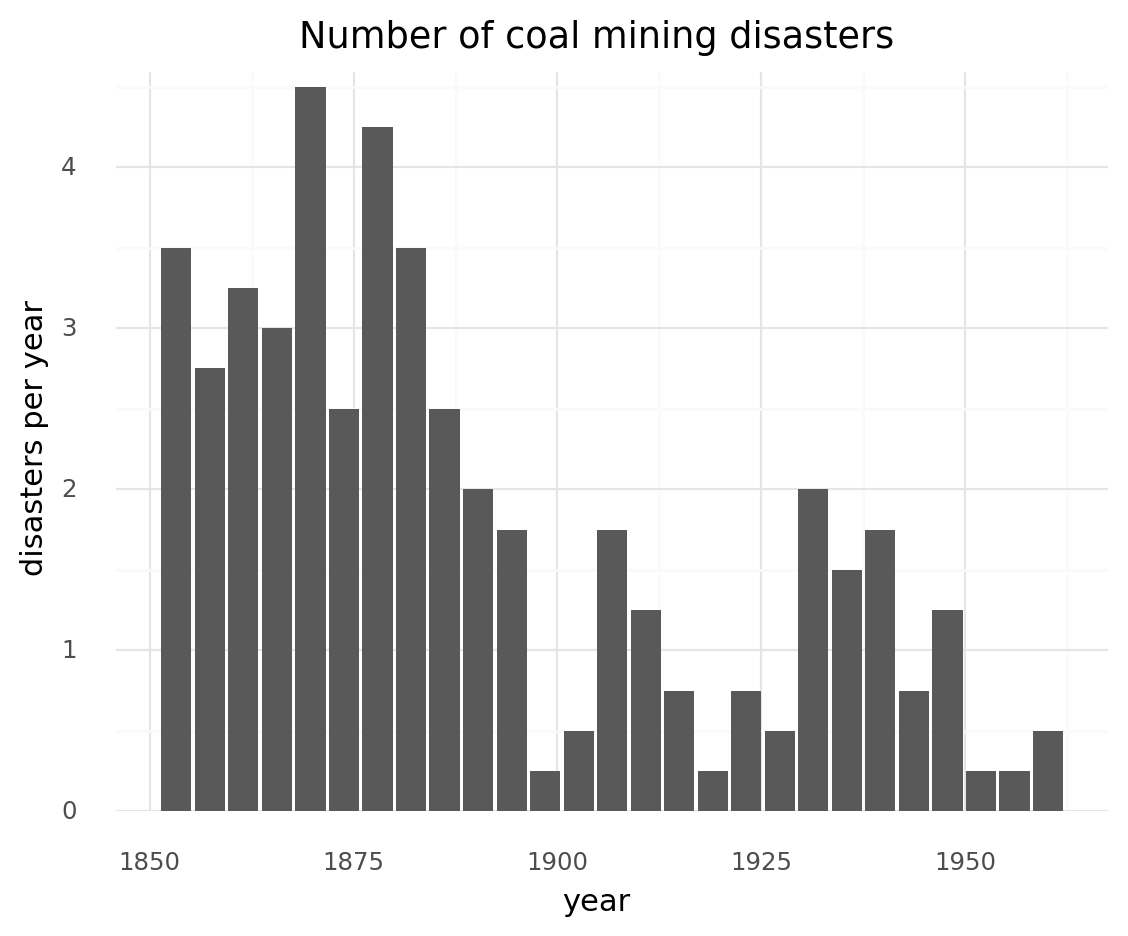

<ggplot: (8791700652138)>

In [39]:
plot_df = pd.DataFrame({"x": x_centers, "y": y_data})
(
    gg.ggplot(plot_df, gg.aes("x", "y"))
    + gg.geom_col()
    + gg.scale_y_continuous(expand=(0, 0, 0.02, 0))
    + gg.labs(x="year", y="disasters per year", title="Number of coal mining disasters")
)

In [40]:
with pm.Model() as model_coal:
    l = pm.HalfNormal("l", X_data.std())
    cov = pm.gp.cov.ExpQuad(1, l) + pm.gp.cov.WhiteNoise(1e-5)
    gp = pm.gp.Latent(cov_func=cov)
    f = gp.prior("f", X=X_data)

    y_pred = pm.Poisson("y_pred", mu=pm.math.exp(f), observed=y_data)
    trace_coal = pm.sample(1000, chains=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [f_rotated_, l]


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 29 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


/usr/local/Caskroom/miniconda/base/envs/bayesian-analysis-with-python_e2/lib/python3.9/site-packages/arviz/stats/stats.py:484: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions


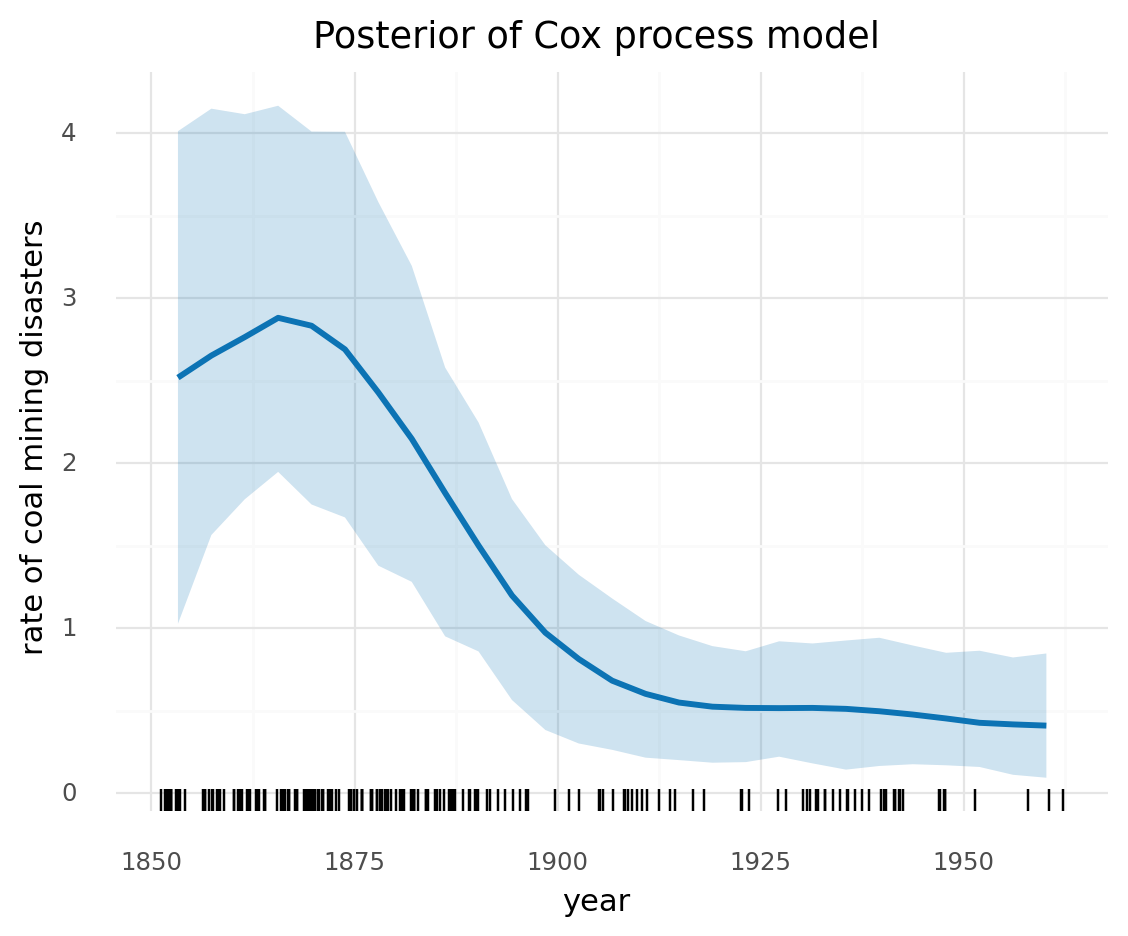

<ggplot: (8791699348110)>

In [41]:
f_trace = np.exp(trace_coal["f"])
rate_median = np.median(f_trace, axis=0)

rate_hdi = pd.DataFrame(az.hdi(f_trace, hdi_prob=0.89), columns=["hdi_low", "hdi_high"])
rate_hdi["x"] = x_centers
rate_hdi["median"] = rate_median

(
    gg.ggplot(rate_hdi, gg.aes(x="x"))
    + gg.geom_ribbon(gg.aes(ymin="hdi_low", ymax="hdi_high"), alpha=0.2, fill="#0C73B4")
    + gg.geom_line(gg.aes(y="median"), size=1.2, color="#0C73B4")
    + gg.geom_rug(gg.aes(x="time"), data=coal_df)
    + gg.labs(
        x="year",
        y="rate of coal mining disasters",
        title="Posterior of Cox process model",
    )
)

### The redwood dataset

- example:
    - data is locations of redwood trees
    - objective it to identify how the rate of trees is distributed
    - data needs to be binned to be units of rate per area

In [42]:
rw_df = pd.read_csv(data_path / "redwood.csv", header=None, names=["x1", "x2"])
rw_df.head()

,x1,x2
0,0.931481,0.817680
1,0.938889,0.764273
2,0.935185,0.721915
3,0.979630,0.664825
4,0.787037,0.661142


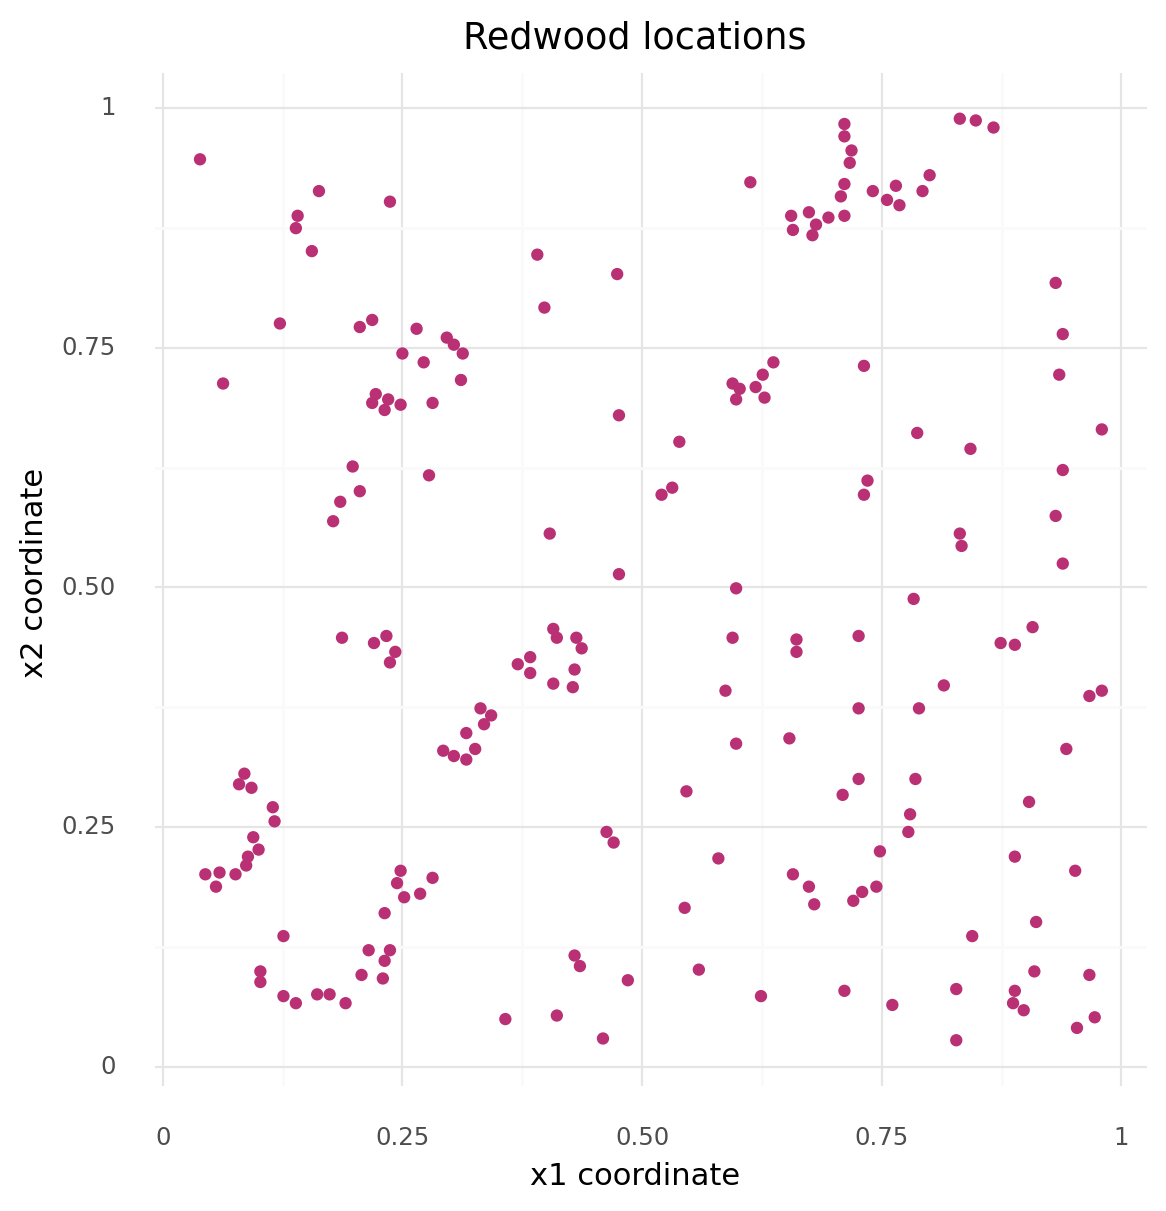

<ggplot: (8791699304551)>

In [43]:
(
    gg.ggplot(rw_df, gg.aes("x1", "x2"))
    + gg.geom_point(color="#B93174")
    + gg.coord_equal()
    + gg.labs(x="x1 coordinate", y="x2 coordinate", title="Redwood locations")
)

- instead of doing a mesh grid, treat `x1` and `x2` separately
    - can then build a covariance matrix for each, reducing the size of the matrix needed to compute the GP
    - need to use the `LatentKron()` class for the GP
    - this is not a numerical trick (not an approximation), just leads to faster computation

In [44]:
n_bins = 20
hist, x1_edges, x2_edges = np.histogram2d(rw_df.x2.values, rw_df.x1.values, bins=n_bins)
x1_centers = x1_edges[:-1] + (x1_edges[1] - x1_edges[0]) / 2.0
x2_centers = x2_edges[:-1] + (x2_edges[1] - x2_edges[0]) / 2.0

X_data = [x1_centers[:, None], x2_centers[:, None]]
y_data = hist.flatten()

with pm.Model() as model_rw:
    l = pm.HalfNormal("l", rw_df.std().values, shape=2)
    cov1 = pm.gp.cov.ExpQuad(1, l[0])
    cov2 = pm.gp.cov.ExpQuad(1, l[1])
    gp = pm.gp.LatentKron(cov_funcs=[cov1, cov2])
    f = gp.prior("f", Xs=X_data)

    y = pm.Poisson("y", mu=pm.math.exp(f), observed=y_data)
    trace_rw = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [f_rotated_, l]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 120 seconds.
The estimated number of effective samples is smaller than 200 for some parameters.


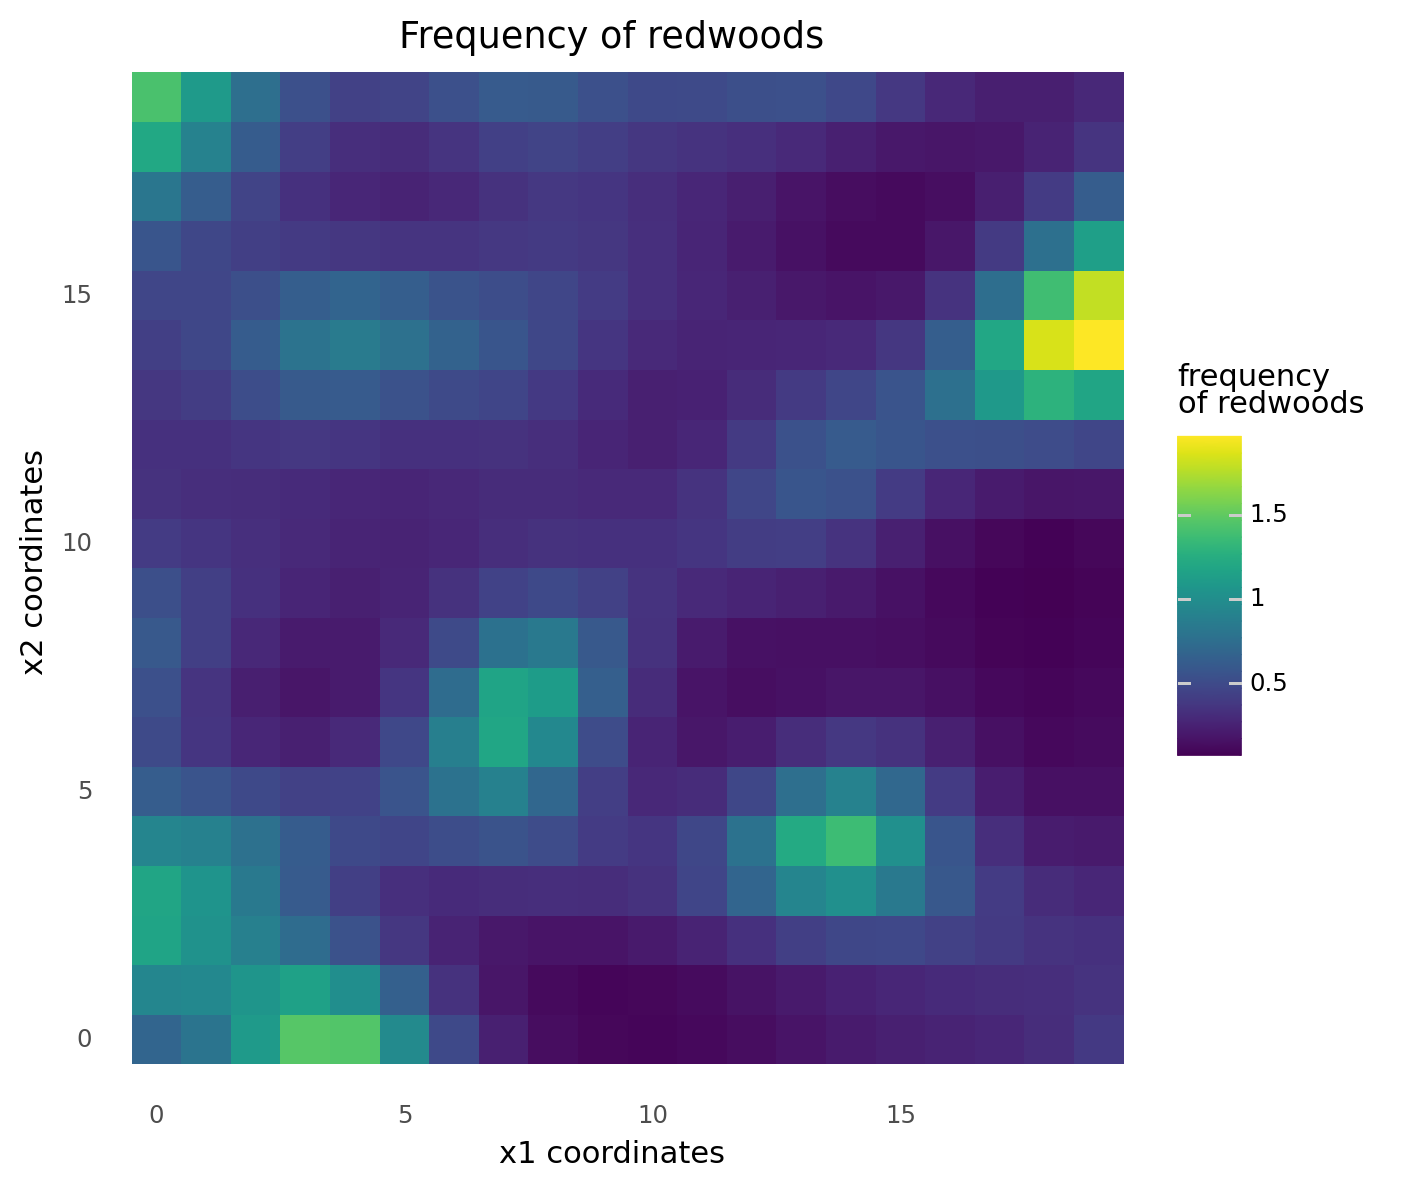

<ggplot: (8791699355847)>

In [45]:
rates = np.exp(np.mean(trace_rw["f"], axis=0).reshape(hist.shape))
rates_df = (
    pd.DataFrame(rates)
    .reset_index(drop=False)
    .rename(columns={"index": "x1"})
    .melt(id_vars="x1", var_name="x2", value_name="rate")
    .assign(x2=lambda d: d.x2.astype(int))
)

(
    gg.ggplot(rates_df, gg.aes("x1", "x2"))
    + gg.geom_tile(gg.aes(fill="rate"))
    + gg.scale_x_continuous(expand=(0, 0))
    + gg.scale_y_continuous(expand=(0, 0))
    + gg.coord_equal()
    + gg.theme(legend_title=gg.element_text(va="bottom"))
    + gg.labs(
        x="x1 coordinates",
        y="x2 coordinates",
        title="Frequency of redwoods",
        fill="frequency\nof redwoods",
    )
)

---

In [46]:
%load_ext watermark
%watermark -d -u -v -iv -b -h -m

Last updated: 2021-01-08

Python implementation: CPython
Python version       : 3.9.1
IPython version      : 7.19.0

Compiler    : Clang 10.0.0 
OS          : Darwin
Release     : 20.1.0
Machine     : x86_64
Processor   : i386
CPU cores   : 4
Architecture: 64bit

Hostname: JHCookMac

Git branch: master

numpy     : 1.19.4
theano    : 1.0.5
matplotlib: 3.3.3
arviz     : 0.10.0
scipy     : 1.6.0
pandas    : 1.2.0
plotnine  : 0.7.1
seaborn   : 0.11.1
pymc3     : 3.9.3

